In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ipywidgets
from ipywidgets import interact, interact_manual
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

# Calculate the Binary LGE hit or miss ratios
Between LGE Segments and Segments defined by Circle or Tarique

## Column: 'Tarique abnormal'

bullsplot used here
tarique, bullsplot, motion curves
11 - mid inferolateral 

first: quality check: single segments only is very rare, two segments are better/more often that means more plausible. Not just the septum is affected. If all segments are affected, tracking may be wrong. 
second: based on experience, 11 and 12 AHA are mostly affected. Check also on circumferential and radial strain values, are they low? Bullseye plot is used for help.

## Column: 'Strain diff' 

Bezieht sich auf die orginal column: 'Segment from strain if different'

- tarique says this is difference between D and F
- tarique says this column is not helpful
- tarique says this columns relates to if different from LGE

He also said that this column shows the additional segments when he applies the Strain thresholding



# Define some helper functions

In [9]:

def cross_validate_f1(x,y):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams.update({'font.size': 16})
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)
    cv = 5
    
    clf1 = LogisticRegression(random_state=1, class_weight='balanced', max_iter=1000)
    clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')) #RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf3 = GaussianNB()
    clf4 = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(class_weight='balanced'))
    clf5 = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(random_state=42, n_components=2), KNeighborsClassifier(n_neighbors=2))
    clf6 = make_pipeline(StandardScaler(), SVC(kernel='poly',gamma='auto',class_weight='balanced', C=1, degree=3))
    clf7 = SVC(kernel='poly', gamma='auto',class_weight='balanced')
    # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    # NeighborhoodComponentsAnalysis(n_components=10, random_state=random_state),
    
    eclf = VotingClassifier(
        estimators=[
            #('lr', clf1), 
             
            ('lr', clf1), 
            ('rf', clf2), 
            ('svc', clf6),
            ('dt', clf4)
                   ],
        voting='hard')
    
    fig, ax = plt.subplots(1,8, figsize=(25,5))
    i = 0
    for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'scaled DecissionTree', 'KNN', 'scaled SVC(poly)', 'SVC(poly)', 'Ensemble']):
        
        y_pred = cross_val_predict(clf, x, y, cv=cv)
        scores = cross_validate(clf, x, y, scoring=['f1','recall', 'balanced_accuracy'], cv=cv)
        print('*'*10,label,'*'*10)
        print(scores['test_recall'])
        print("F1: %0.2f (+/- %0.2f) [%s]" % (scores['test_f1'].mean(), scores['test_f1'].std(), label))
        print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), label))
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_balanced_accuracy'].mean(), scores['test_balanced_accuracy'].std(), label))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, labels=[1,0],ax=ax[i], colorbar=False)
        ax[i].set_title(label)
        ax[i].xaxis.label.set_visible(False)
        ax[i].yaxis.label.set_visible(False)
        i = i + 1
    plt.show()

# Read the dmd dataframe with all timesteps

In [3]:
from ipyfilechooser import FileChooser
import os
path_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/ablation/'), '')
display(path_chooser)

FileChooser(path='/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/ablation', filename='', title=…

In [4]:
#/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2
#df_strain_comp = pd.read_csv('/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2/df_DMD_time_ed2p.csv')
#df_strain_p2p = pd.read_csv('/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2/df_DMD_time_p2p.csv')
df_strain_comp = pd.read_csv(os.path.join(path_chooser.selected, 'df_DMD_time_ed2p.csv'))
df_strain_p2p = pd.read_csv(os.path.join(path_chooser.selected,'df_DMD_time_p2p.csv'))
df_strain_comp.sort_values(by=['pat', 'aha'], inplace=True)
df_strain_p2p.sort_values(by=['pat', 'aha'], inplace=True)

df_strain_comp = df_strain_comp.fillna(df_strain_comp.mean())
df_strain_p2p = df_strain_p2p.fillna(df_strain_p2p.mean())

print(df_strain_comp[df_strain_comp.isna().any(axis=1)])
print(df_strain_p2p[df_strain_p2p.isna().any(axis=1)])
print(df_strain_comp.shape)
print(df_strain_p2p.shape)
df_strain_comp.head()
# we need to make sure that we differentate lge pos/neg on a patient level on all segments, not only on the segments of interest
y = (df_strain_p2p.sort_values(['pat']).groupby('pat')['lge'].sum()>0).values
print(y.sum())
print((y==False).sum())
df_strain_comp.describe()

Empty DataFrame
Columns: [pat, aha, phase, our_rs, our_cs, soa, lge]
Index: []
Empty DataFrame
Columns: [pat, aha, phase, our_rs, our_cs, soa, lge]
Index: []
(4560, 7)
(4560, 7)
33
24


aha        phase       our_rs       our_cs          soa  \
count  4560.000000  4560.000000  4560.000000  4560.000000  4560.000000   
mean      8.500000     2.000000     4.700274    -0.369574     0.108553   
std       4.610278     1.414369     4.957189     0.140774     0.311111   
min       1.000000     0.000000     0.067676    -0.499999     0.000000   
25%       4.750000     1.000000     0.925481    -0.487463     0.000000   
50%       8.500000     2.000000     3.241635    -0.430255     0.000000   
75%      12.250000     3.000000     6.880445    -0.279481     0.000000   
max      16.000000     4.000000    38.506970    -0.034646     1.000000   

               lge  
count  4560.000000  
mean      0.205044  
std       0.403778  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [6]:
df_strain_p2p_positive = df_strain_p2p[df_strain_p2p['lge']==1]
temp = df_strain_p2p_positive.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_p2p.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_p2p_pos.xlsx'))

In [7]:
df_strain_p2p_negative = df_strain_p2p[df_strain_p2p['lge']==0]
temp = df_strain_p2p_negative.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_p2p.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_p2p_neg.xlsx'))

In [8]:
# Calc the mean/std for the phase2phases strain per patient, export as xlsx
temp = df_strain_p2p.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_p2p.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_p2p_mean.xlsx'))

In [9]:
# Calc the mean/std for the composed strain per patient, export as xlsx
temp = df_strain_comp.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_comp.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_comp_mean.xlsx'))

In [10]:
temp

our_rs_mean  our_cs_mean  our_rs_std  our_cs_std
aha phase                                                  
1   0         0.879806     0.089290    0.398987    0.068014
    1         1.075437     0.148970    0.605217    0.093149
    2         0.658606     0.071887    0.321721    0.048374
    3         0.111531     0.001926    0.081021    0.012156
    4         0.003178     0.004315    0.009424    0.006549
...                ...          ...         ...         ...
16  0         0.272984     0.000857    0.181541    0.032843
    1         0.709379    -0.005076    0.257008    0.040408
    2         0.287029    -0.015934    0.230191    0.030687
    3         0.018638    -0.003388    0.015524    0.005383
    4        -0.004293     0.005913    0.008082    0.012554

[80 rows x 4 columns]

In [13]:
# test, if we use only the mid-cavity segments, this performs better, than taking all segments into account
# only freewall
segments_of_interest = [4,5,6,11,12]
# only mid-cavity
#segments_of_interest =[5,6,7,8,9,10,11,12]
df_strain_p2p = df_strain_p2p[df_strain_p2p['aha'].isin(segments_of_interest)]
df_strain_comp = df_strain_comp[df_strain_comp['aha'].isin(segments_of_interest)]

In [55]:
df_strain_comp.head()

pat  aha  phase    our_rs    our_cs  soa  lge
20  aa_20180710    5      0  0.003685  0.051645  0.0  0.0
21  aa_20180710    5      1  0.913108  0.121693  0.0  0.0
22  aa_20180710    5      2  0.261745  0.014910  0.0  0.0
23  aa_20180710    5      3  0.013298 -0.003892  0.0  0.0
24  aa_20180710    5      4 -0.015184  0.001413  0.0  0.0

# Violinplots of RS/CS per phase grouped by binary lge

In [12]:
temp = np.array([range(10)])
np.roll(temp, -1)

array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 0]])

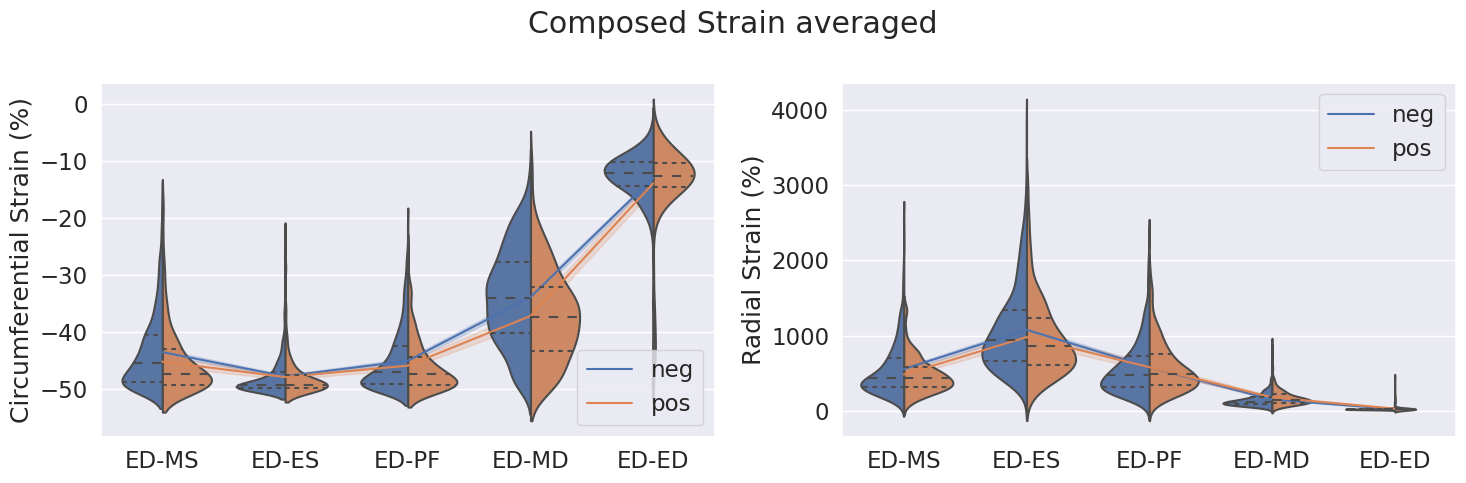

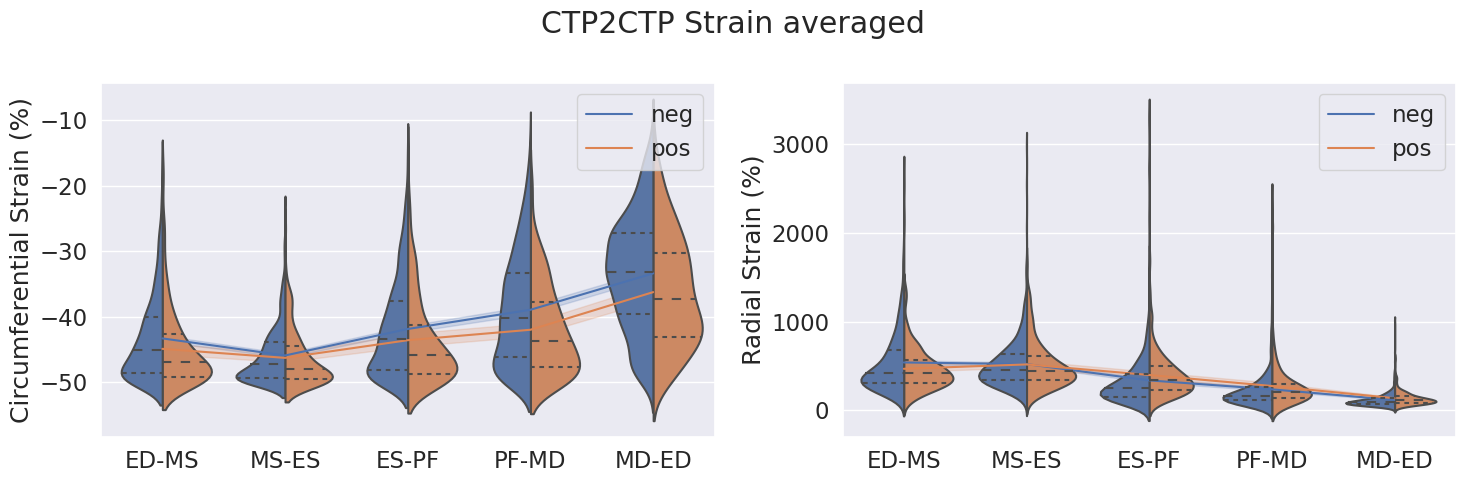

In [6]:
def plot_strain_per_time(df, title=None, p2p=False):
    import seaborn
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    # scale to % values
    df = df.copy()
    df['our_rs'] = df['our_rs'] * 100
    df['our_cs'] = df['our_cs'] * 100
    
    if p2p:
        phases = ['ED-MS','MS-ES','ES-PF','PF-MD','MD-ED']
    else:
        phases = ['ED-MS','ED-ES','ED-PF','ED-MD','ED-ED']
    ax1, ax2 = ax
    ax1 = sb.lineplot(x="phase", y="our_cs",
                      hue="lge",
                      err_style='band', legend=False,ax=ax1,
                 data=df)
    ax1 = sb.violinplot(x="phase", y="our_cs",inner='quart',
                   ax=ax1,
                 data=df, 
                        split=True,hue='lge'
                       )
    #_ = ax1.set_ylim((-15., 25))
    _ = ax1.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax1.set_xticklabels(phases)
    _ = ax1.legend(['neg','pos'])
    _ = ax1.set_xlabel('')
    _ = ax1.set_ylabel('Circumferential Strain (%)')

    ax2 = sb.lineplot(x="phase", y="our_rs",
                 hue="lge",
                      err_style='band', legend=False,ax=ax2,
                 data=df)
    ax2 = sb.violinplot(x="phase", y="our_rs",inner='quart',
                   ax=ax2,
                 data=df, 
                        split=True,hue='lge'
                       )

    #_ = ax2.set_ylim((-25, 150))
    _ = ax2.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax2.set_xticklabels(phases)
    _ = ax2.legend(['neg','pos'])
    _ = ax2.set_xlabel('')
    _ = ax2.set_ylabel('Radial Strain (%)')
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    return fig
    
#print('*'*20,'strain composed','*'*20)
_ = plot_strain_per_time(df_strain_comp,title='Composed Strain averaged',p2p=False); plt.show()
#print('*'*20,'strain p2p','*'*20)
_ = plot_strain_per_time(df_strain_p2p, title='CTP2CTP Strain averaged',p2p=True);plt.show()

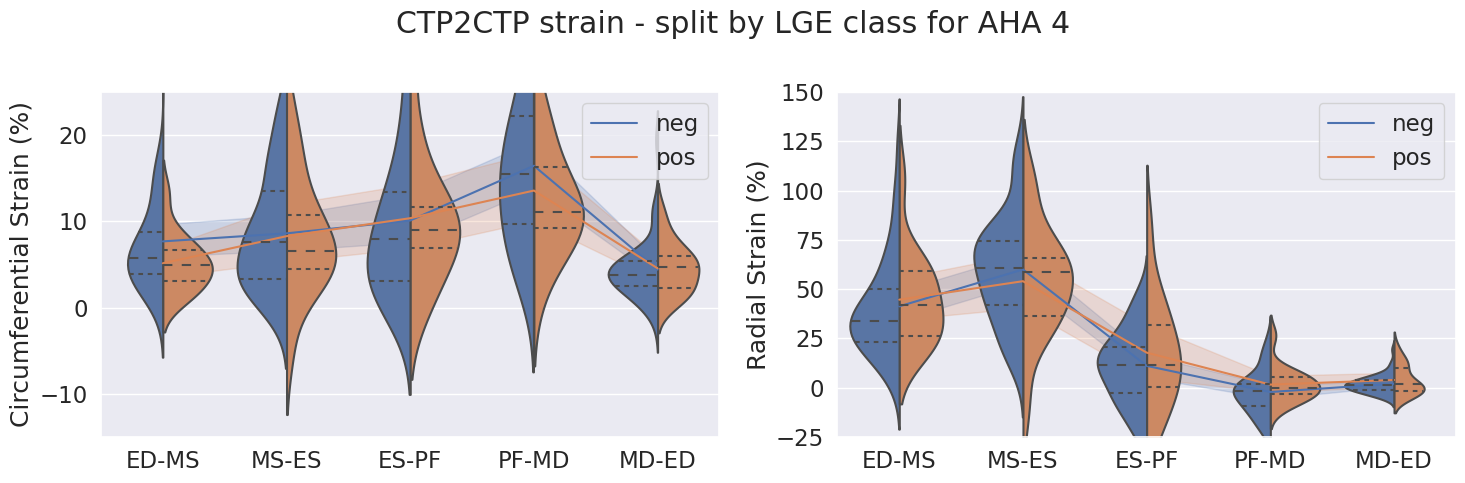

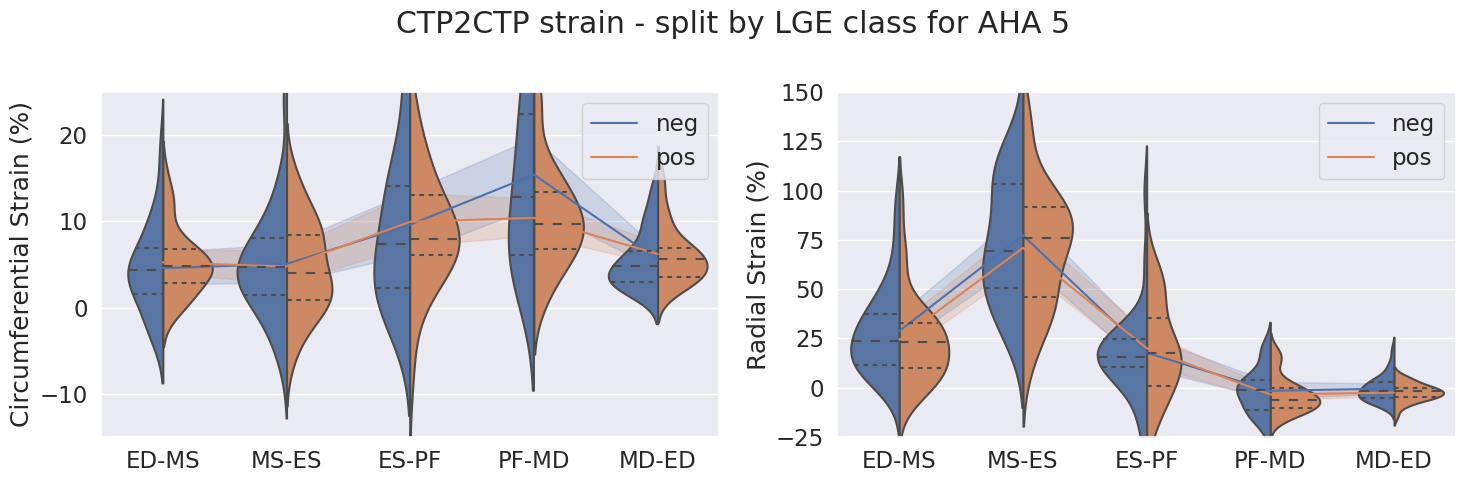

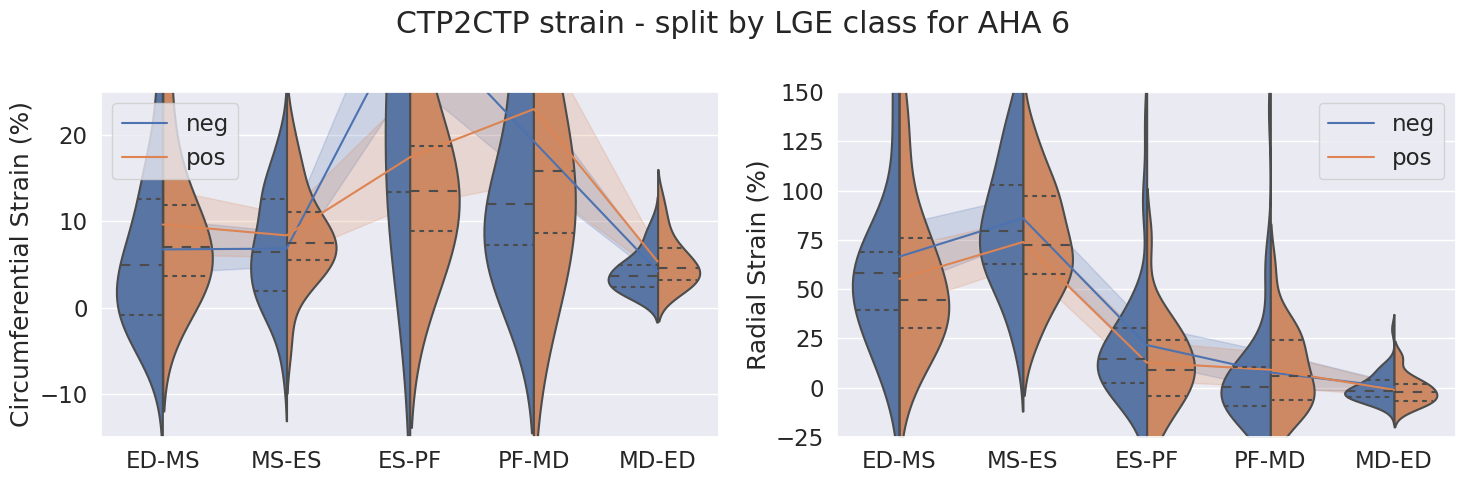

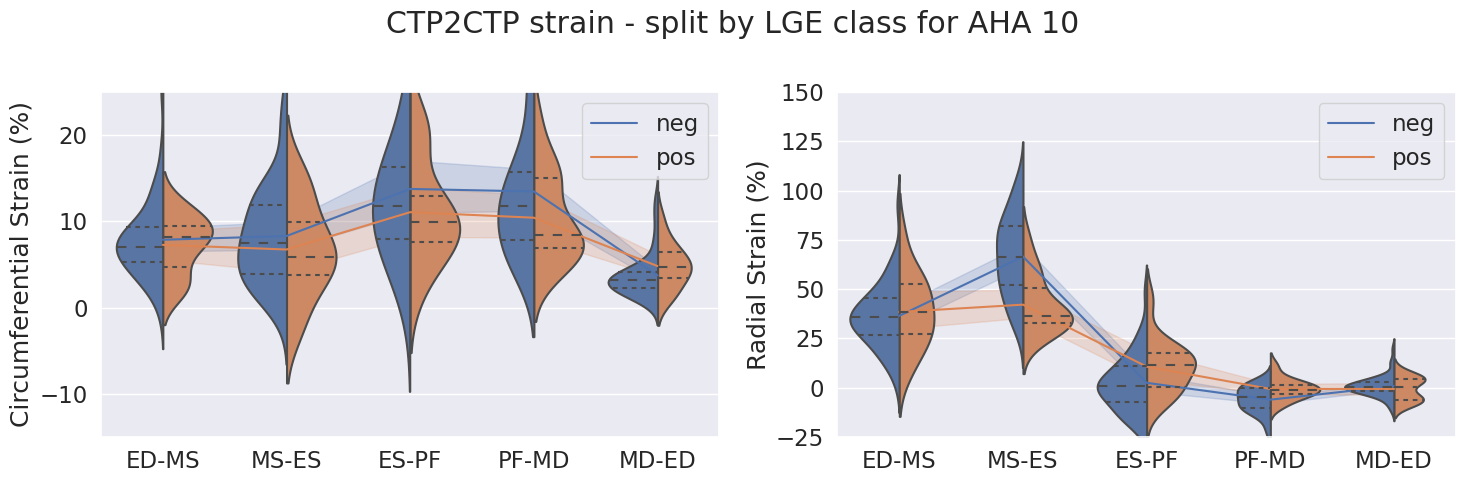

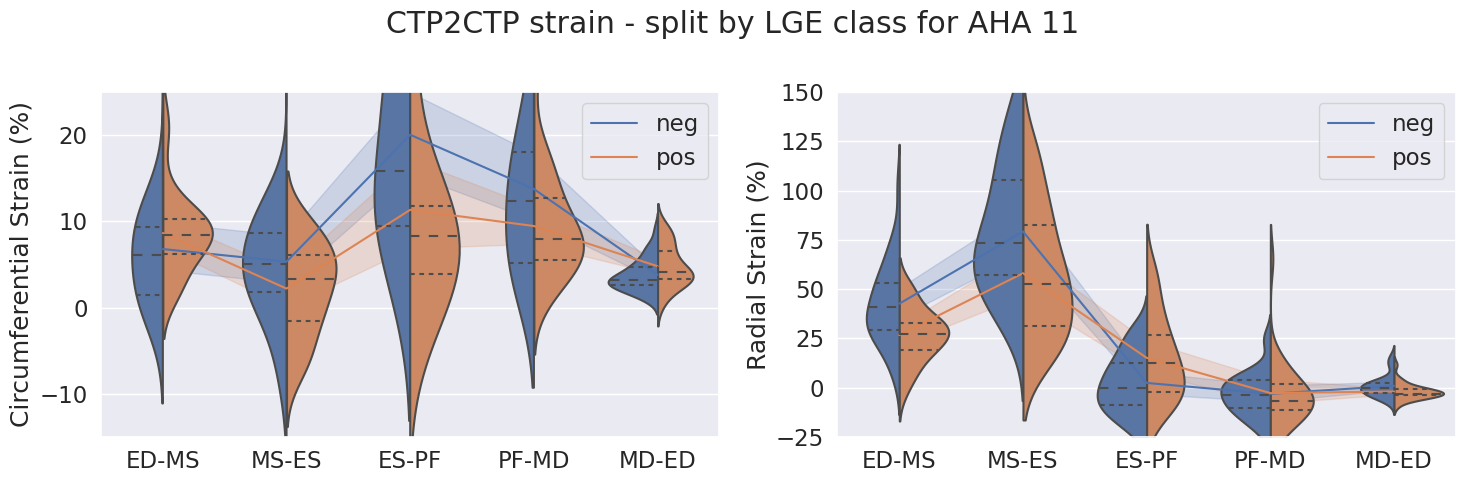

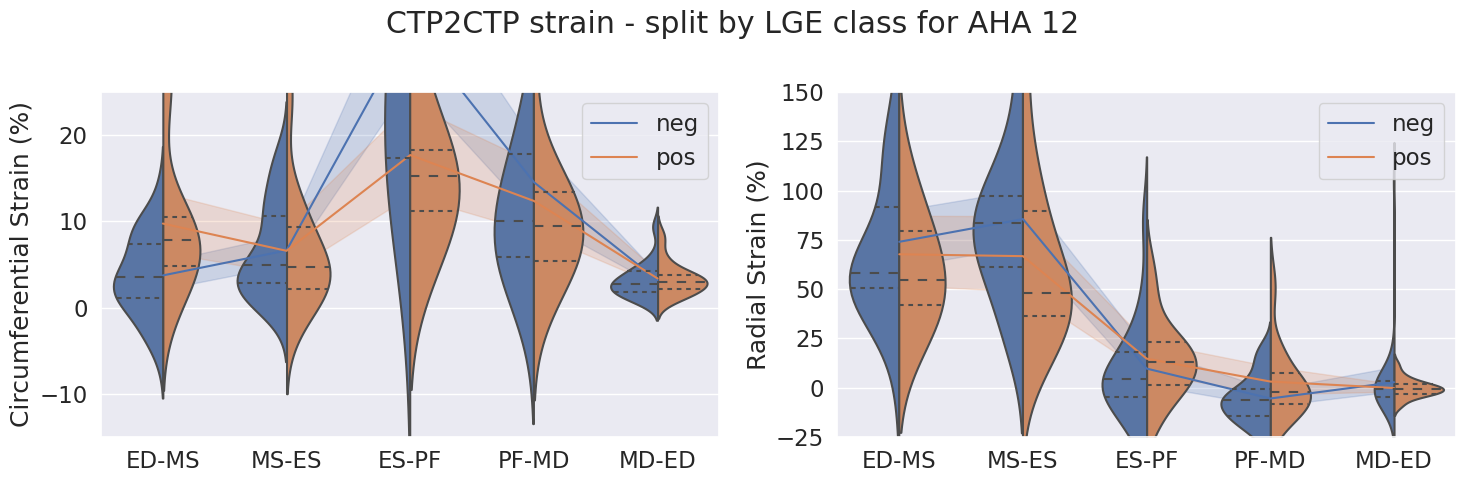

In [30]:
# plot one violinplot per mid-cavity segment for the p2p strains
segments_of_interest = [4,5,6,11,12]
for i in segments_of_interest:
    temp = df_strain_p2p[df_strain_p2p['aha']==i]
    _ = plot_strain_per_time(temp, title="CTP2CTP strain - split by LGE class for AHA {}".format(i), p2p=True);plt.show()

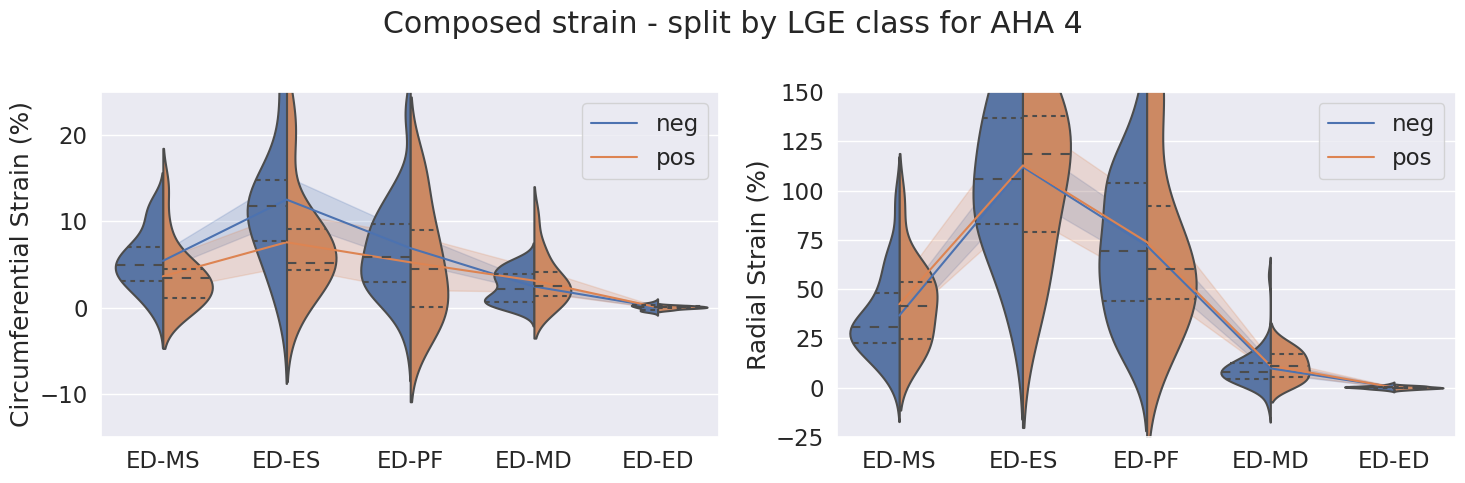

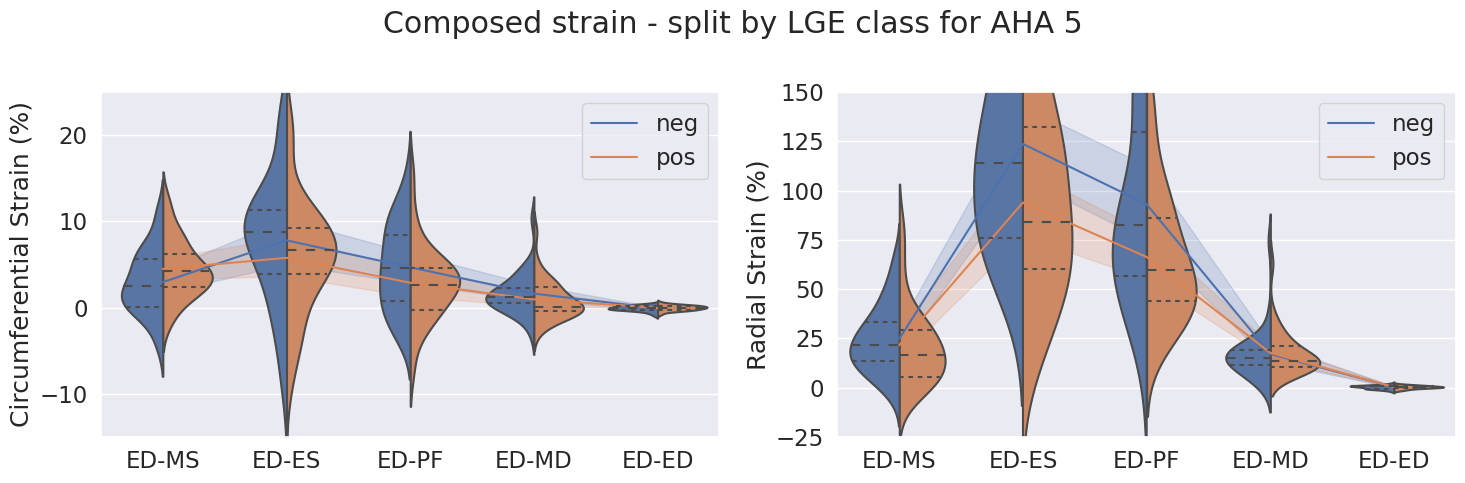

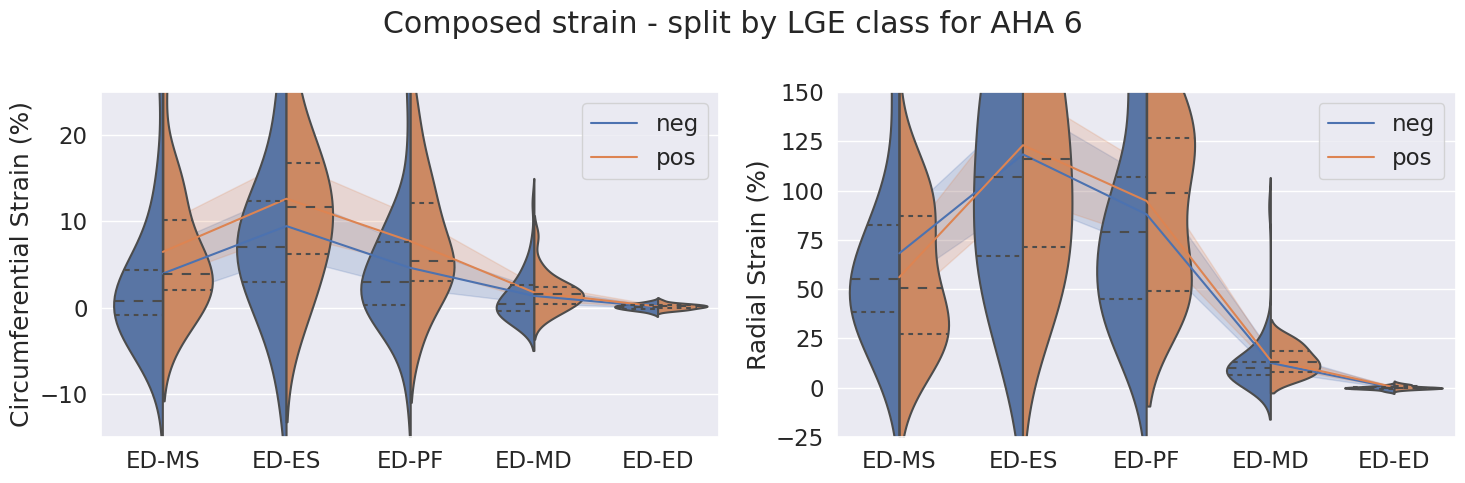

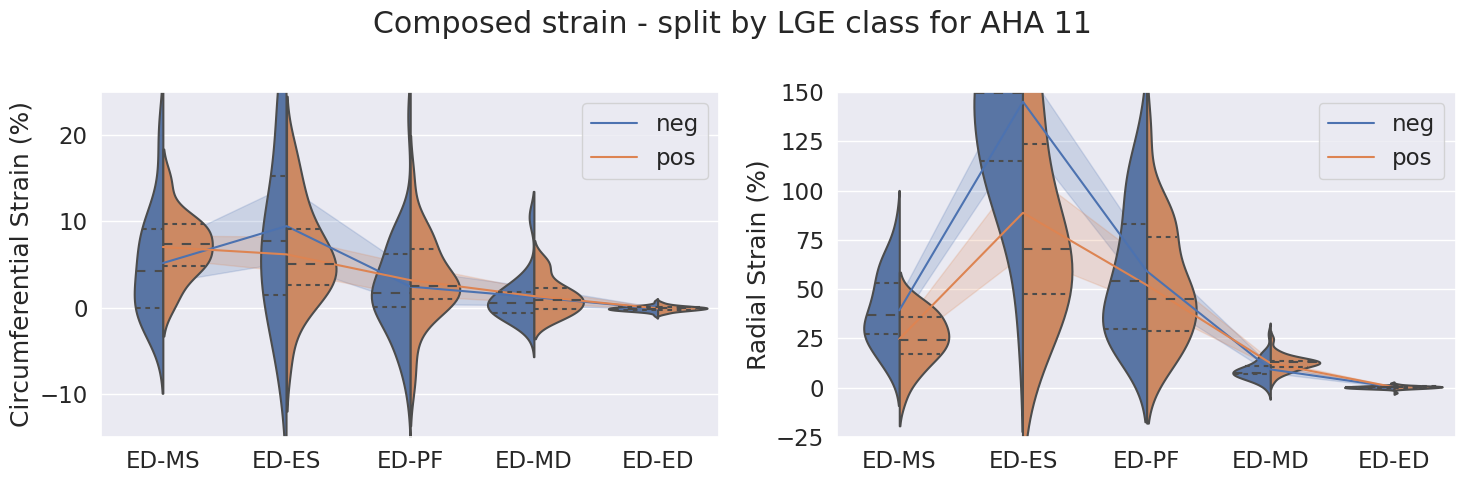

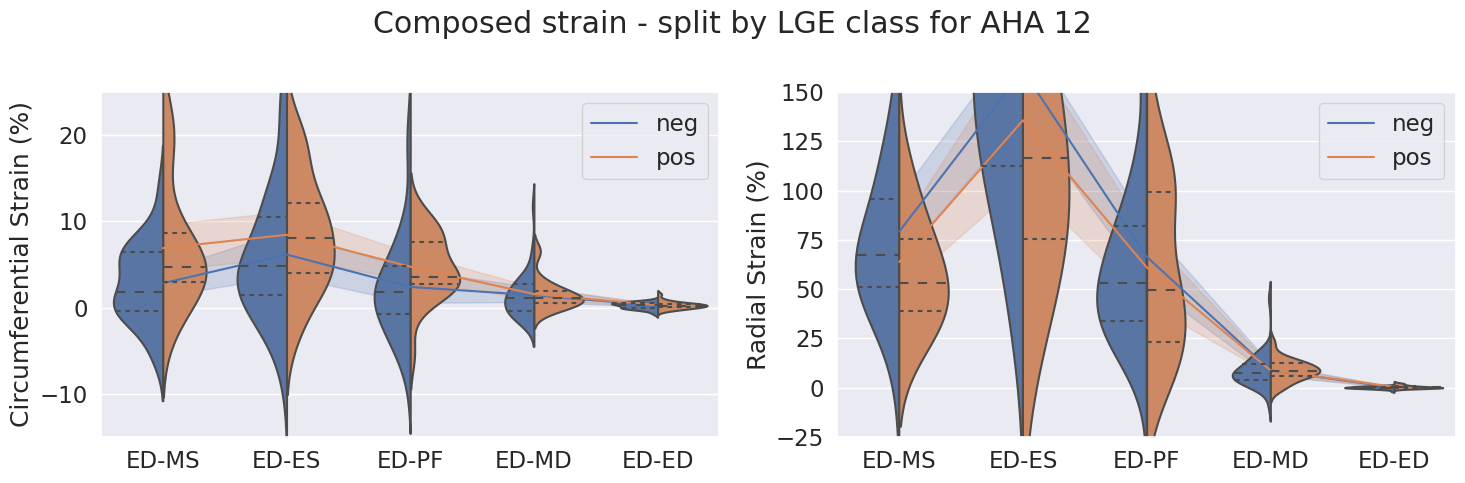

In [7]:
# plot one violinplot per mid-cavity segment for the comp strains
for i in segments_of_interest:
    temp = df_strain_comp[df_strain_comp['aha']==i]
    _ = plot_strain_per_time(temp, title="Composed strain - split by LGE class for AHA {}".format(i), p2p=False)

In [15]:
#df_strain_comp.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
#df_strain_p2p.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [77]:
#df_strain_comp = df_strain_comp[~df_strain_comp['pat'].isin(['wc_20181015'])]
#df_strain_p2p = df_strain_p2p[~df_strain_p2p['pat'].isin(['wc_20181015'])]

# Identify pcs und prs 
- by max/min or by 
- a pre-defined phase (eg.: ES)

In [7]:
def get_peak_rs_cs(df, per_phase=True):
    
    if per_phase:
        # by phase
        pcs = df[df['phase']==1]['our_cs'].values
        prs = df[df['phase']==1]['our_rs'].values
        
    else:
        # get the peak radial and circumferential strains from all time steps
        # min/max
        pcs = np.stack(df.groupby(['phase'])['our_cs'].apply(list).values).astype(np.float32)
        pcs = pcs.min(axis=0)
        prs = np.stack(df.groupby(['phase'])['our_rs'].apply(list).values).astype(np.float32)
        prs = prs.max(axis=0)
        
    return prs, pcs

# peak radial and circumferential strain
# for the composed and p2p strain values
prs_com_p, pcs_com_p = get_peak_rs_cs(df_strain_comp, per_phase=True)
prs_com_arg, pcs_com_arg = get_peak_rs_cs(df_strain_comp, per_phase=False)
prs_p2p_p, pcs_p2p_p = get_peak_rs_cs(df_strain_p2p, per_phase=True)
prs_p2p_arg, pcs_p2p_arg = get_peak_rs_cs(df_strain_p2p, per_phase=False)
    
# 56 patients x 16 segments = 896 --> Peak strain per patient and segment
df_peak = df_strain_comp[df_strain_comp['phase']==0].copy()

# composed phase
df_peak['prs_com_p']=prs_com_p
df_peak['pcs_com_p']=pcs_com_p
# composed arg-min/max
df_peak['prs_com_arg']=prs_com_arg
df_peak['pcs_com_arg']=pcs_com_arg
# p2p phase
df_peak['prs_p2p_p']=prs_p2p_p
df_peak['pcs_p2p_p']=pcs_p2p_p
# p2p arg-min/max
df_peak['prs_p2p_arg']=prs_p2p_arg
df_peak['pcs_p2p_arg']=pcs_p2p_arg
# minor cleaning and dtype casting
df_peak.drop(labels='phase', axis=1, inplace=True)
df_peak.drop(labels='our_rs', axis=1, inplace=True)
df_peak.drop(labels='our_cs', axis=1, inplace=True)
df_peak.sort_values(by=['pat', 'aha'], inplace=True)
df_peak = df_peak.apply(lambda x: x.astype(np.float32, errors='ignore'), axis=0)
print(df_peak.dtypes)
print(df_peak.shape)

df_peak.head()

pat             object
aha            float32
soa            float32
lge            float32
prs_com_p      float32
pcs_com_p      float32
prs_com_arg    float32
pcs_com_arg    float32
prs_p2p_p      float32
pcs_p2p_p      float32
prs_p2p_arg    float32
pcs_p2p_arg    float32
dtype: object
(912, 12)


pat  aha  soa  lge  prs_com_p  pcs_com_p  prs_com_arg  \
0   aa_20180710  1.0  0.0  0.0  17.359409  -0.499928    23.655642   
5   aa_20180710  2.0  0.0  0.0  14.612133  -0.491295    14.612133   
10  aa_20180710  3.0  0.0  0.0   3.596335  -0.393467     3.596335   
15  aa_20180710  4.0  0.0  0.0   3.273967  -0.448884     4.117073   
20  aa_20180710  5.0  0.0  0.0   7.566226  -0.492634     7.566226   

    pcs_com_arg  prs_p2p_p  pcs_p2p_p  prs_p2p_arg  pcs_p2p_arg  
0     -0.499928  11.235773  -0.490160    23.337399    -0.499531  
5     -0.491295   4.608113  -0.497561     4.608113    -0.497561  
10    -0.393467   2.440676  -0.496913     3.325340    -0.496913  
15    -0.448884   5.950511  -0.498892     5.950511    -0.499187  
20    -0.492634  10.124890  -0.468922    10.124890    -0.470453

# Examples of dataframe grouby

In [13]:
temp_y = np.stack(df_strain_comp.groupby(['phase'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=0)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(5, 912)
LGE positive patients:  187
LGE negative patients:  725


In [14]:
temp_y = np.stack(df_strain_comp.groupby(['phase','aha'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=0)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(80, 57)
LGE positive patients:  33
LGE negative patients:  24


In [15]:
# best groupby selection for patient and segment based target y
temp_y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
print('LGE positive segments: ',(temp_y==True).sum())
print('LGE negative segments: ',(temp_y==False).sum())
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(57, 80)
LGE positive segments:  935
LGE negative segments:  3625
LGE positive patients:  33
LGE negative patients:  24


In [16]:
temp_y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
temp_y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(57, 16)
LGE positive patients:  33
LGE negative patients:  24


# Peak Strain via argmax or static phase slicing

Phases: [0:4] --> ED,MS,ES,PF,MD
Usually min(cs) and max(rs) should reflect the phase MS--> ES, which sould be phase==1

In [17]:
# for a patient based pos/neg splitting we need a list of patients with LGE pos and LGE neg
temp_y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
pat_pos = df_strain_comp.pat.unique()[temp_y_patients==True]
pat_neg = df_strain_comp.pat.unique()[temp_y_patients==False]
print('LGE positive segments: ',(temp_y==True).sum())
print('LGE negative segments: ',(temp_y==False).sum())
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(57, 80)
LGE positive segments:  935
LGE negative segments:  3625
LGE positive patients:  33
LGE negative patients:  24


In [18]:
# peak strain values per LGE positive group
pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_peak_positive = df_peak[df_peak['pat'].isin(pat_pos)] * 100
df_peak_positive.describe()

aha      soa      lge  prs_com_p  pcs_com_p  prs_com_arg  \
count  528.0000 528.0000 528.0000   528.0000   528.0000     528.0000   
mean   850.0000  16.2879  35.4167   105.4652     3.7950     108.4214   
std    461.4144  36.9605  47.8714    55.4309     7.7783      54.4666   
min    100.0000   0.0000   0.0000    -0.9424   -17.5724       9.3163   
25%    475.0000   0.0000   0.0000    67.9955    -0.9183      70.0567   
50%    850.0000   0.0000   0.0000    94.9841     2.6754      98.5065   
75%   1225.0000   0.0000 100.0000   136.5678     7.5722     138.6407   
max   1600.0000 100.0000 100.0000   362.8723    59.6422     362.8723   

       pcs_com_arg  prs_p2p_p  pcs_p2p_p  prs_p2p_arg  pcs_p2p_arg  
count     528.0000   528.0000   528.0000     528.0000     528.0000  
mean       -1.6604    45.5928     0.6008      59.7548      -0.7795  
std         2.6148    25.5904     3.9347      32.0305       3.0709  
min       -17.5724    -7.1742   -13.6748      12.4082     -13.6748  
25%        -2.4398    27.3271    -1.8820      37.5121      -2.4612  
50%        -0.5303    41.9667     0.5000      53.1212      -0.4605  
75%         0.0097    59.6387     2.8773      75.4747       1.3422  
max         0.7261   163.7703    13.8702     252.7103       7.9910

In [19]:
# peak strain values per LGE negative group
df_peak_negative = df_peak[df_peak['pat'].isin(pat_neg)] * 100
df_peak_negative.describe()

aha      soa      lge  prs_com_p  pcs_com_p  prs_com_arg  \
count  384.0000 384.0000 384.0000   384.0000   384.0000     384.0000   
mean   850.0000   3.3854   0.0000   121.4024     3.6454     125.2414   
std    461.5786  18.1090   0.0000    59.5637     8.5772      58.7462   
min    100.0000   0.0000   0.0000    -2.9199   -14.7597       7.1821   
25%    475.0000   0.0000   0.0000    78.0387    -2.3942      84.4347   
50%    850.0000   0.0000   0.0000   116.2834     2.6423     118.6116   
75%   1225.0000   0.0000   0.0000   151.1040     8.0260     154.9501   
max   1600.0000 100.0000   0.0000   403.5270    51.2216     403.5270   

       pcs_com_arg  prs_p2p_p  pcs_p2p_p  prs_p2p_arg  pcs_p2p_arg  
count     384.0000   384.0000   384.0000     384.0000     384.0000  
mean       -2.4232    58.1001     0.6316      70.8512      -1.5008  
std         2.9753    30.8386     5.2595      37.0625       3.2710  
min       -14.7597   -12.1734   -12.7854      12.5887     -12.7854  
25%        -3.9819    36.7067    -2.6508      45.4315      -3.5801  
50%        -1.2467    51.8499     0.0173      60.7976      -1.1480  
75%        -0.1343    77.9722     3.4962      89.4594       0.9078  
max         0.5958   156.6964    21.9523     242.0339       8.5506

In [17]:
# does the strain values come from two different distributions
from scipy import stats
# [c for c in df_peak_negative.columns if 'p2p' in c]
@interact
def p_test(col = df_peak_negative.columns):
    try:
        print(df_peak_negative[col].shape)
        return stats.ttest_ind(df_peak_negative[col], df_peak_positive[col])
    except Exception as e:
        print(e)

interactive(children=(Dropdown(description='col', options=('pat', 'aha', 'soa', 'lge', 'prs_com_p', 'pcs_com_p…

In [20]:
# segment and phase with the maximal difference between LGE pos and negative group
df_strain_p2p_positive = df_strain_p2p[df_strain_p2p['lge']==1]
temp_pos = df_strain_p2p_positive.groupby(['aha','phase']).mean()

df_strain_p2p_negative = df_strain_p2p[df_strain_p2p['lge']==0]
temp_neg = df_strain_p2p_negative.groupby(['aha','phase']).mean()

diff = abs(temp_pos - temp_neg)*100
diff[['our_rs', 'our_cs']]

our_rs  our_cs
aha phase                
1   0     62.1541  3.3955
    1     27.9757  3.4053
    2     24.8005 24.0705
    3      3.3396 24.4642
    4      4.7235  2.8935
...           ...     ...
16  0     12.7937  1.8157
    1     11.0603  1.5968
    2      6.9544  1.9846
    3      4.1987  3.1662
    4      0.1069  0.1090

[80 rows x 2 columns]

******************** strain composed ********************
prs: Counter({1: 787, 2: 90, 0: 35})
pcs: Counter({4: 330, 2: 209, 1: 182, 3: 104, 0: 87})


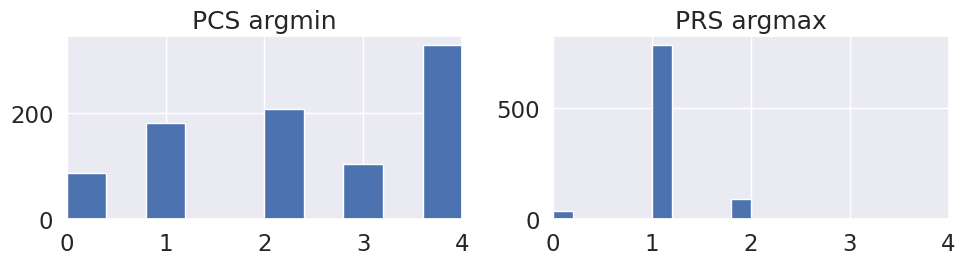

******************** strain p2p ********************
prs: Counter({1: 495, 0: 388, 2: 23, 3: 4, 4: 2})
pcs: Counter({1: 481, 0: 226, 4: 131, 2: 53, 3: 21})


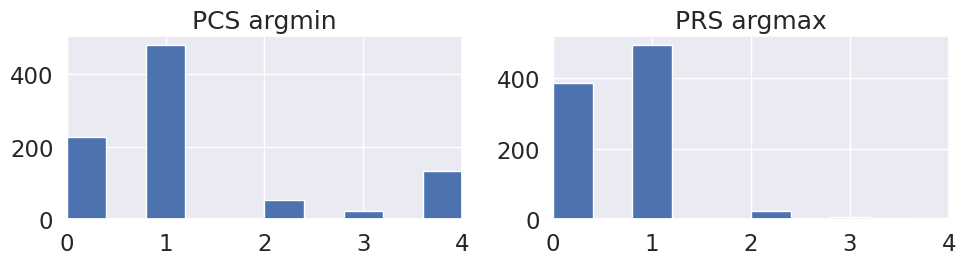

In [21]:
def show_phase_with_max_min_strain(df):
    from collections import Counter
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    # peak radial strain
    rs = np.stack(df.groupby(['pat','aha'])['our_rs'].apply(list).values).astype(np.float32)
    # peak circumferential strain
    cs = np.stack(df.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)

    prs_argmax = np.argmax(rs, axis=1)
    pcs_argmin = np.argmin(cs, axis=1)
    print('prs: {}'.format(Counter(prs_argmax)))
    print('pcs: {}'.format(Counter(pcs_argmin)))

    # plot
    ax[0].hist(pcs_argmin)
    ax[0].set_title('PCS argmin')
    ax[0].set_xlim(0,4)
    ax[1].hist(prs_argmax)
    ax[1].set_title('PRS argmax')
    ax[1].set_xlim(0,4)
    plt.tight_layout()
    plt.show()
    
print('*'*20,'strain composed','*'*20)
show_phase_with_max_min_strain(df_strain_comp)
print('*'*20,'strain p2p','*'*20)
show_phase_with_max_min_strain(df_strain_p2p)

prs: Counter({1: 110, 0: 65, 2: 11, 3: 1})
pcs: Counter({1: 90, 0: 40, 4: 33, 2: 19, 3: 5})


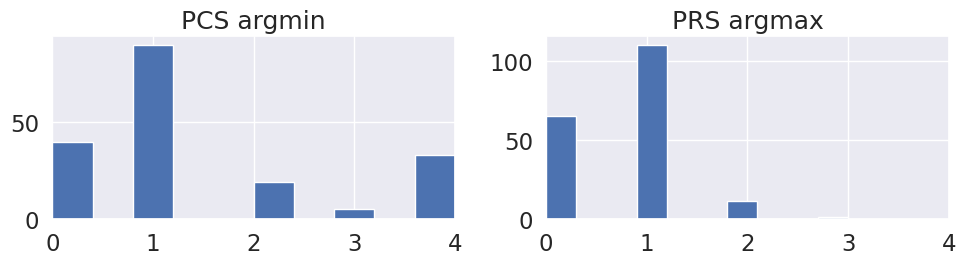

prs: Counter({1: 385, 0: 323, 2: 12, 3: 3, 4: 2})
pcs: Counter({1: 391, 0: 186, 4: 98, 2: 34, 3: 16})


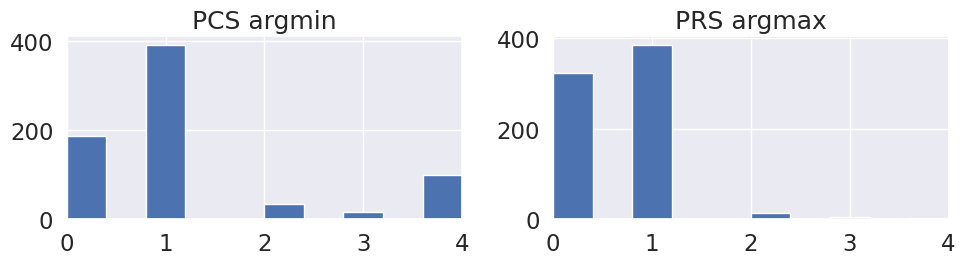

prs: Counter({1: 150, 2: 36, 0: 1})
pcs: Counter({4: 96, 2: 32, 1: 25, 3: 22, 0: 12})


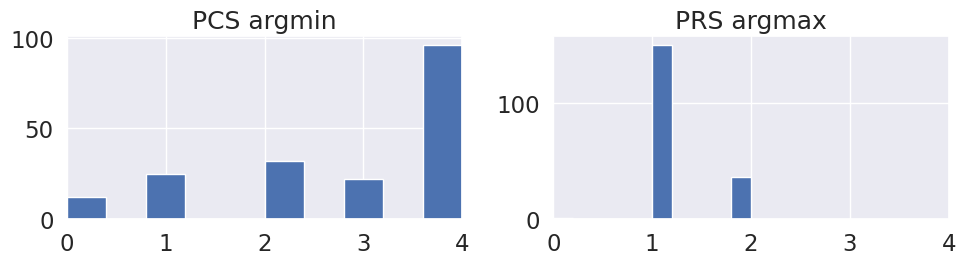

prs: Counter({1: 637, 2: 54, 0: 34})
pcs: Counter({4: 234, 2: 177, 1: 157, 3: 82, 0: 75})


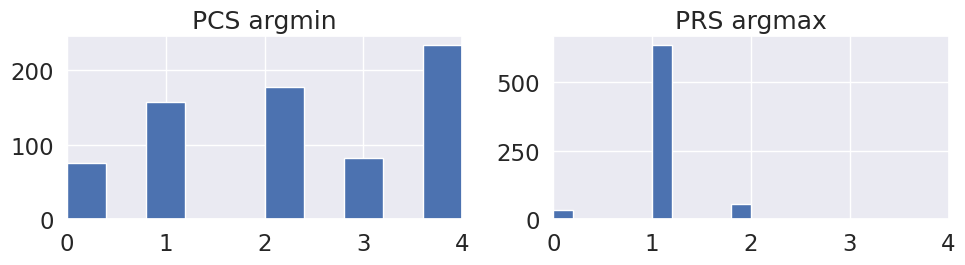

In [22]:
# occurence of the peak and min values per outcome group and strain
df_strain_p2p_positive = df_strain_p2p[df_strain_p2p['lge']==1]
df_strain_p2p_negative = df_strain_p2p[df_strain_p2p['lge']==0]
show_phase_with_max_min_strain(df_strain_p2p_positive)
show_phase_with_max_min_strain(df_strain_p2p_negative)

df_strain_comp_positive = df_strain_comp[df_strain_comp['lge']==1]
df_strain_comp_negative = df_strain_comp[df_strain_comp['lge']==0]
show_phase_with_max_min_strain(df_strain_comp_positive)
show_phase_with_max_min_strain(df_strain_comp_negative)

# Pairplot

## Composed Strain

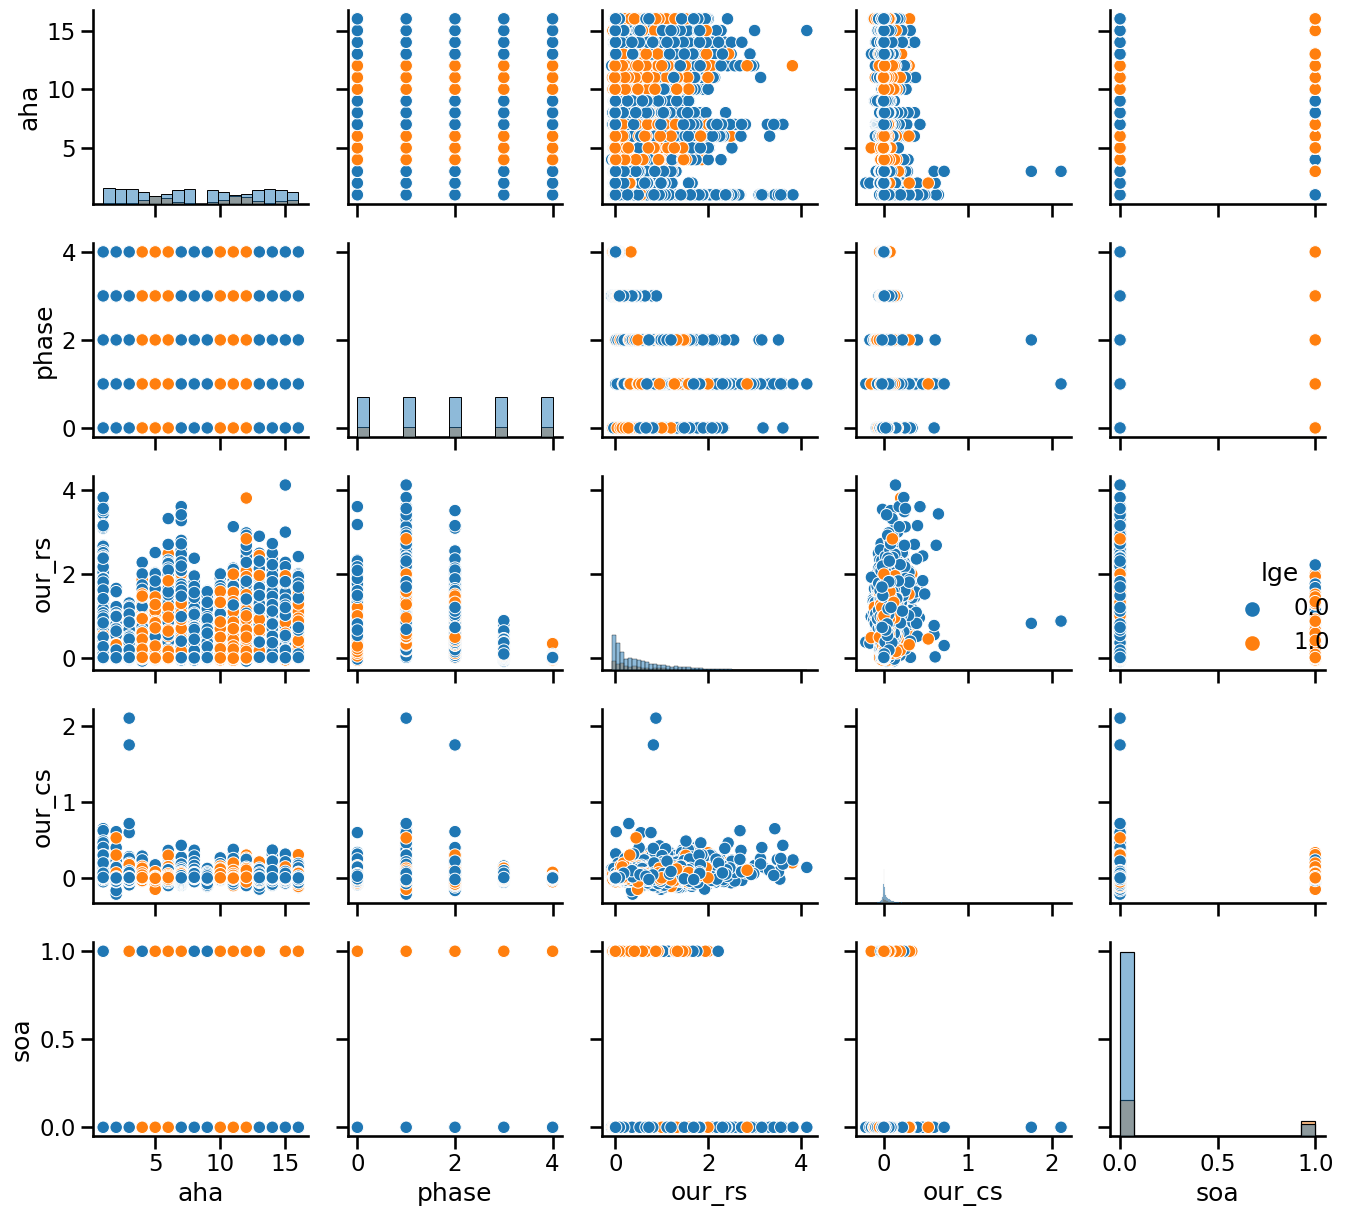

In [22]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain_comp,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

## p2p Strain

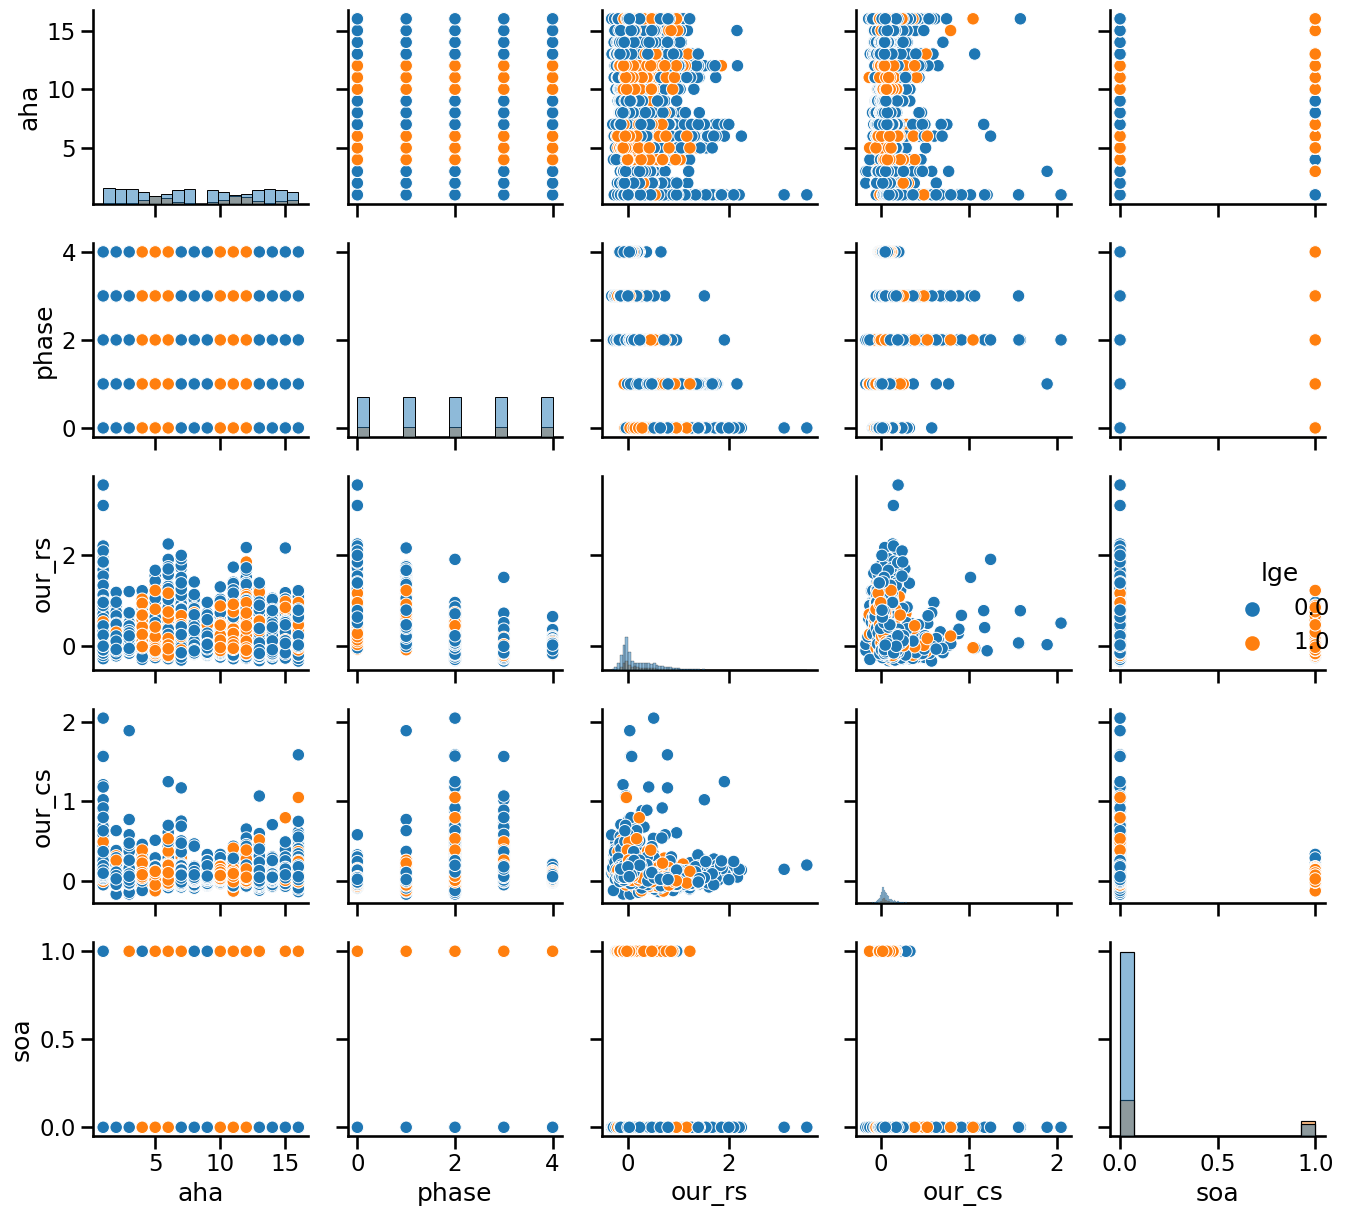

In [23]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain_p2p,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

## Peak Strain

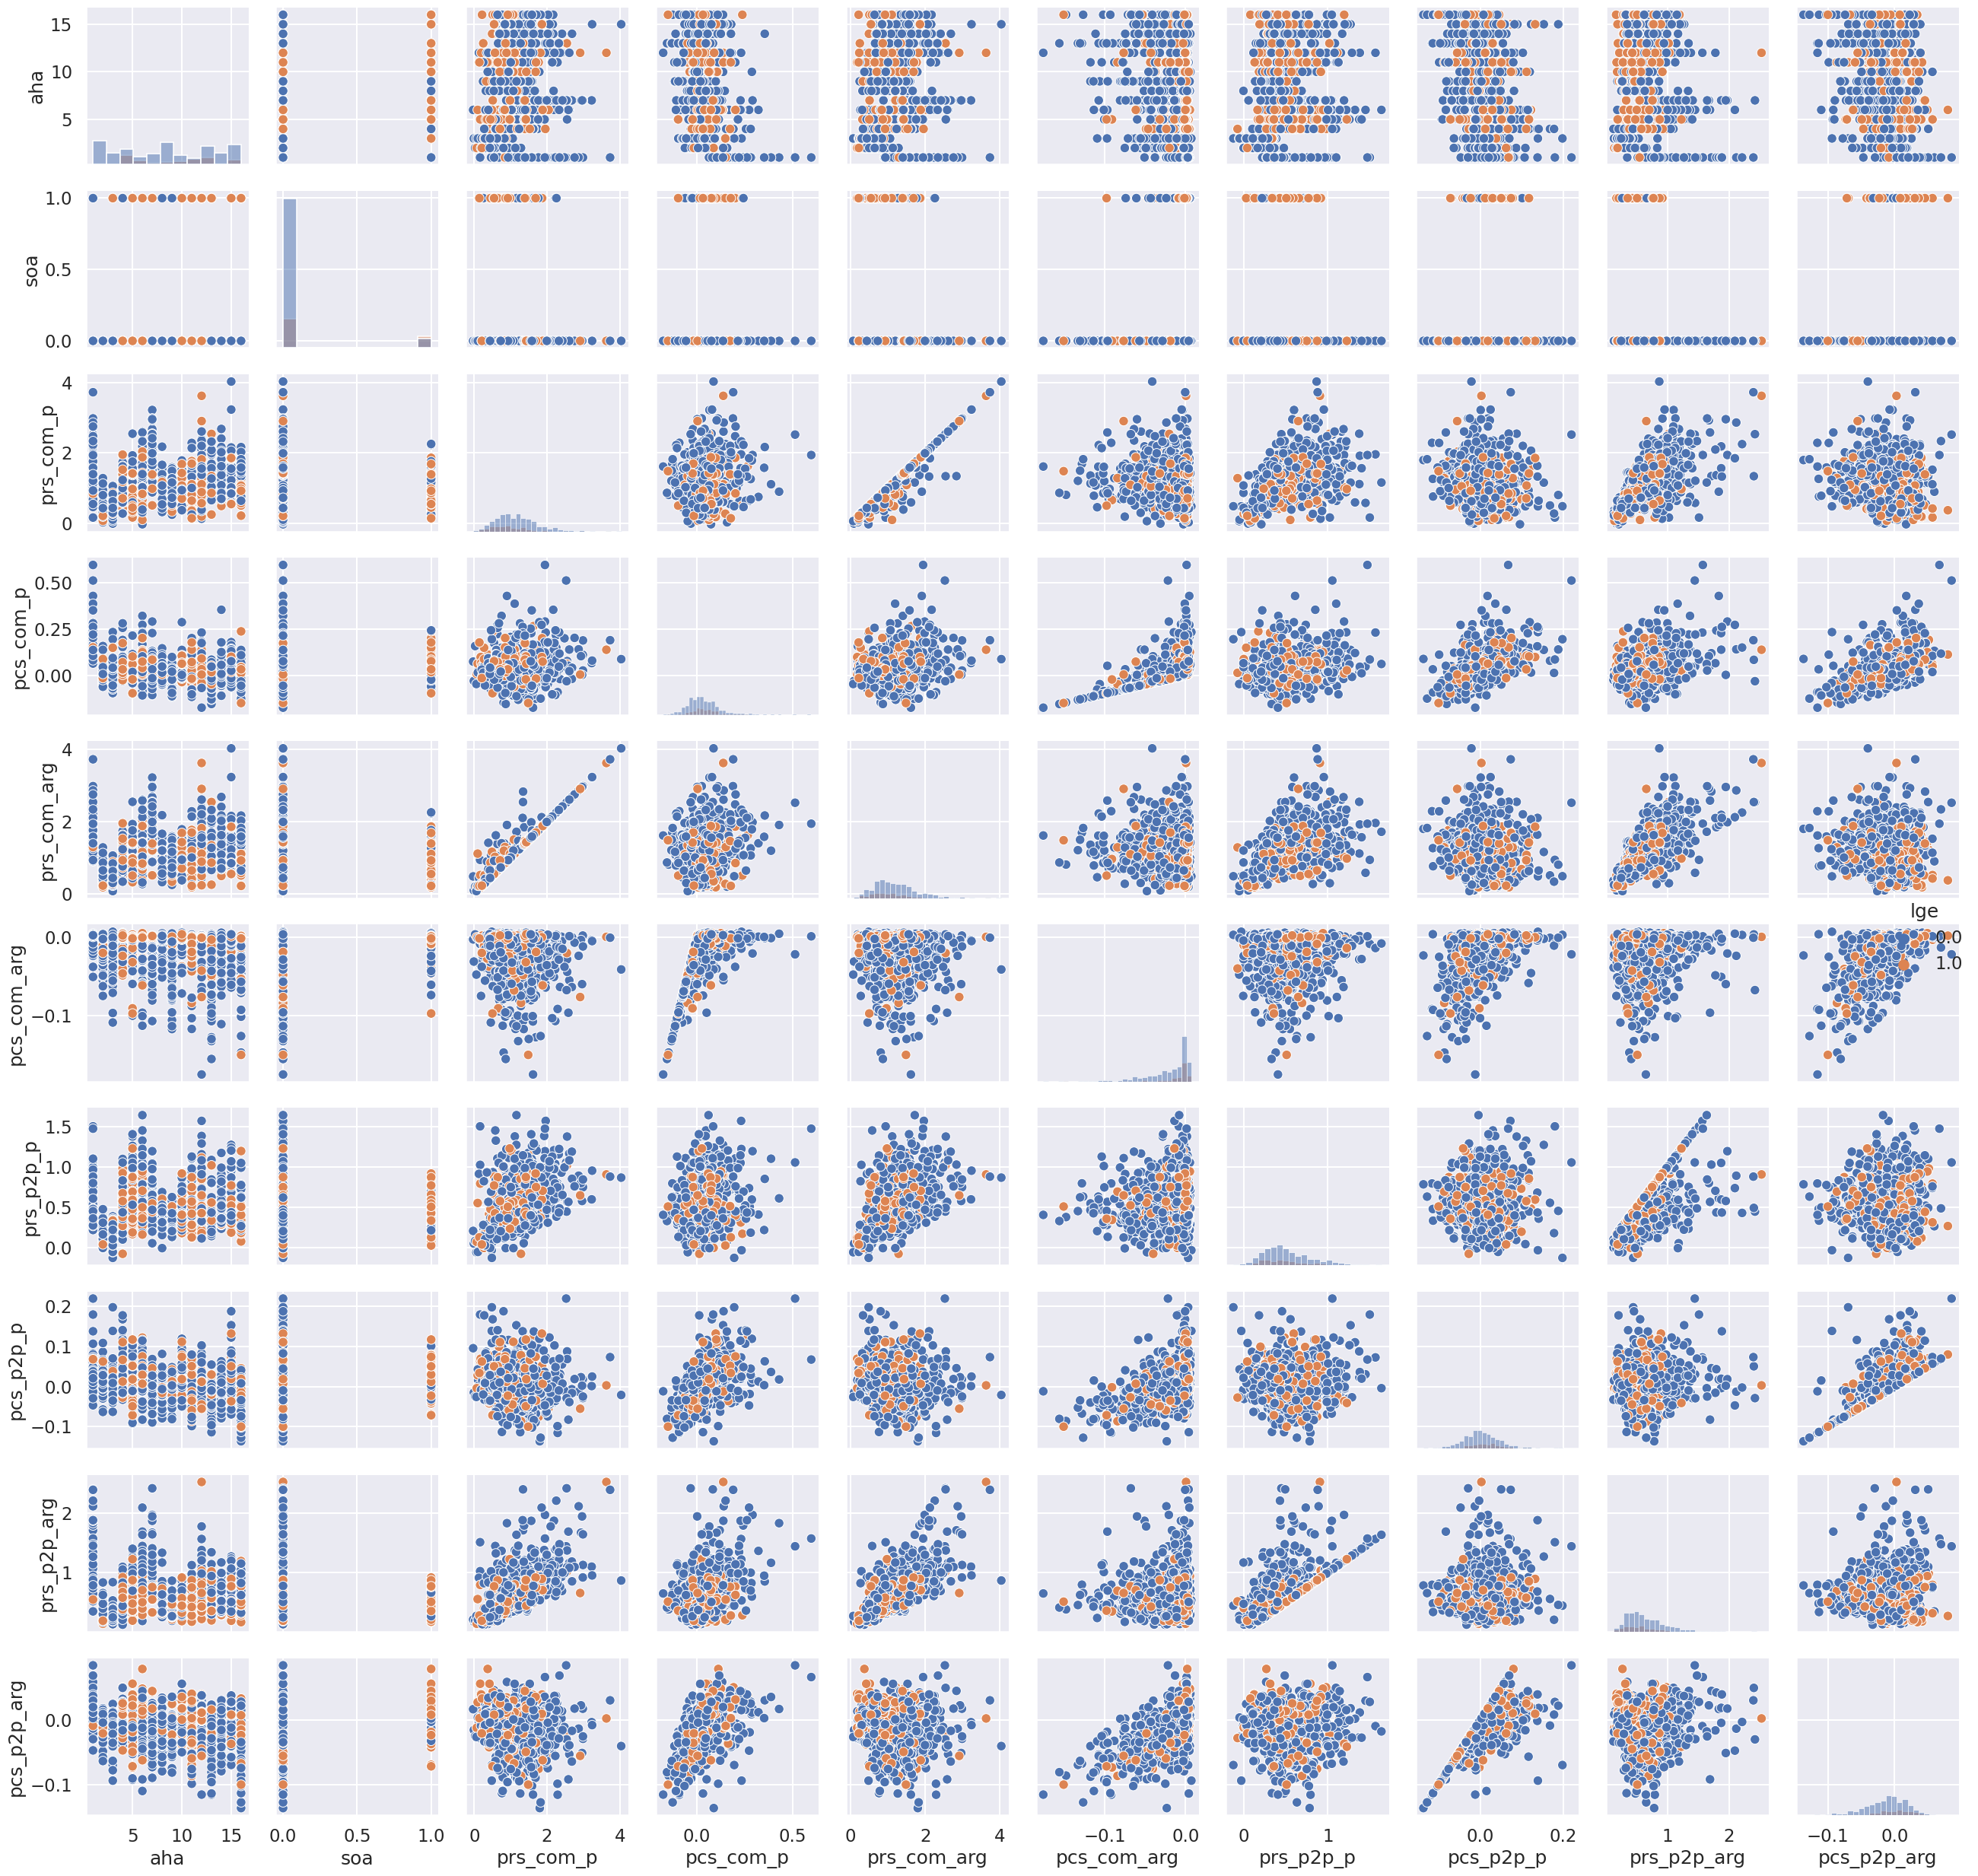

In [25]:
sb.set_context("talk")
g = sb.pairplot(data=df_peak,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

# Correlation plots

## Composed Strain

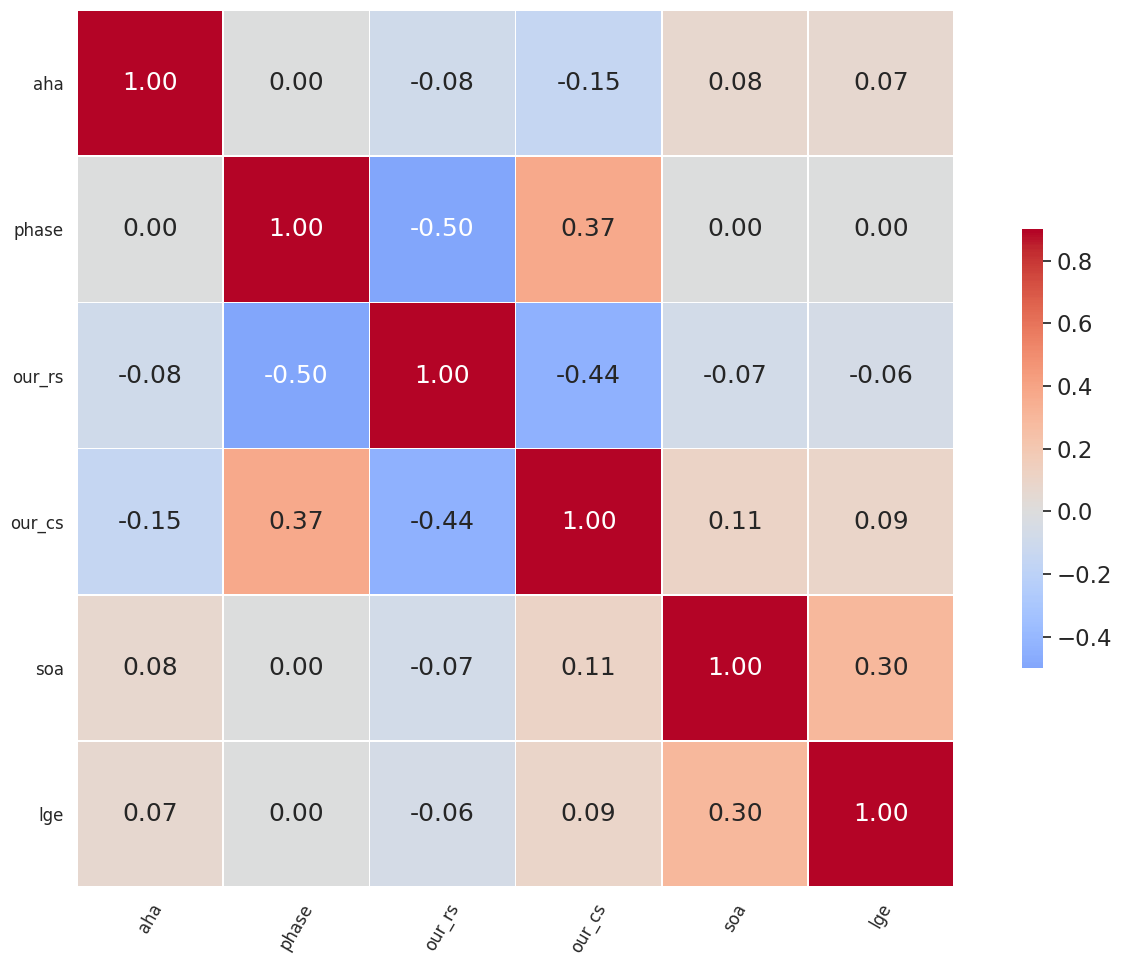

In [7]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain_comp.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()
plt.show()
#fig.savefig('strain_corr_cvi_vs_ours.png')

## p2p Strain

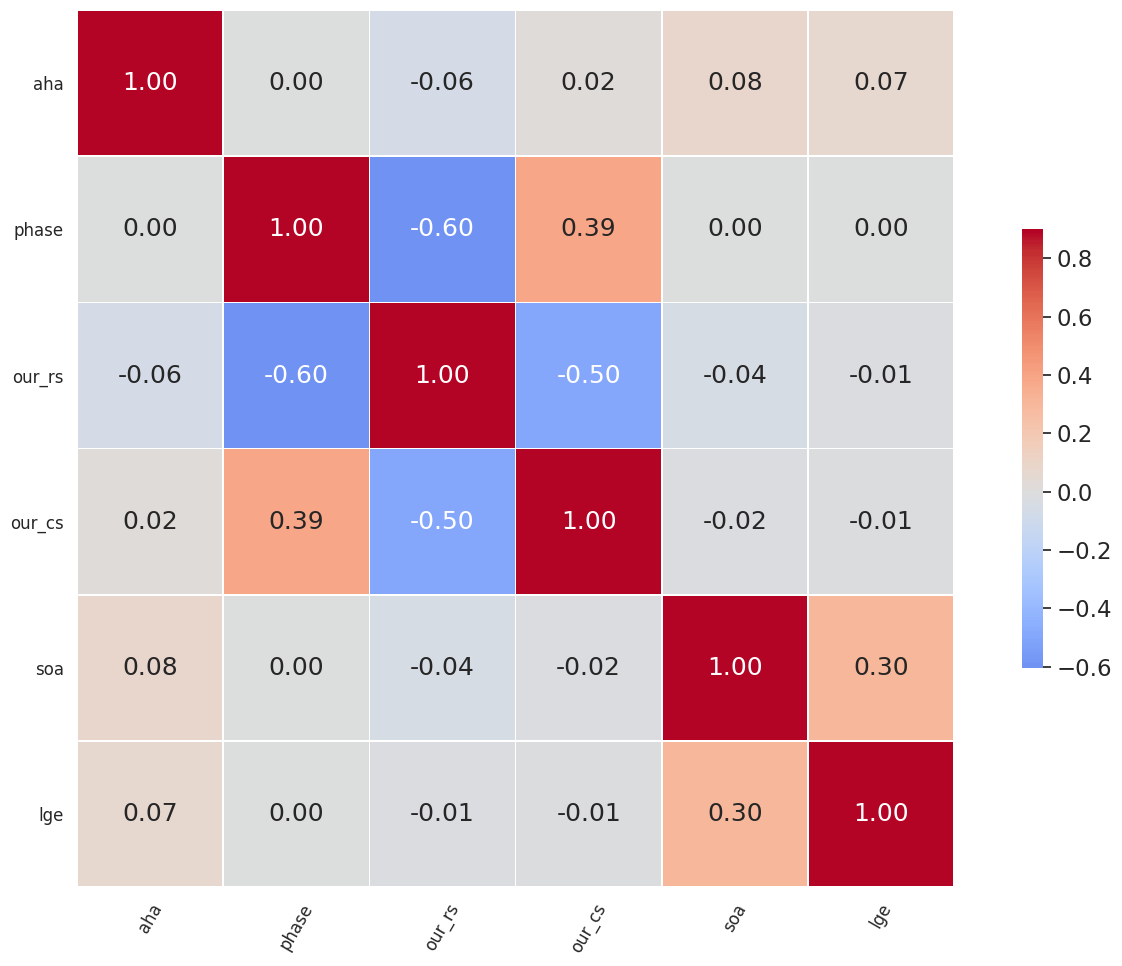

In [8]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain_p2p.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()
plt.show()

## Peak Strain

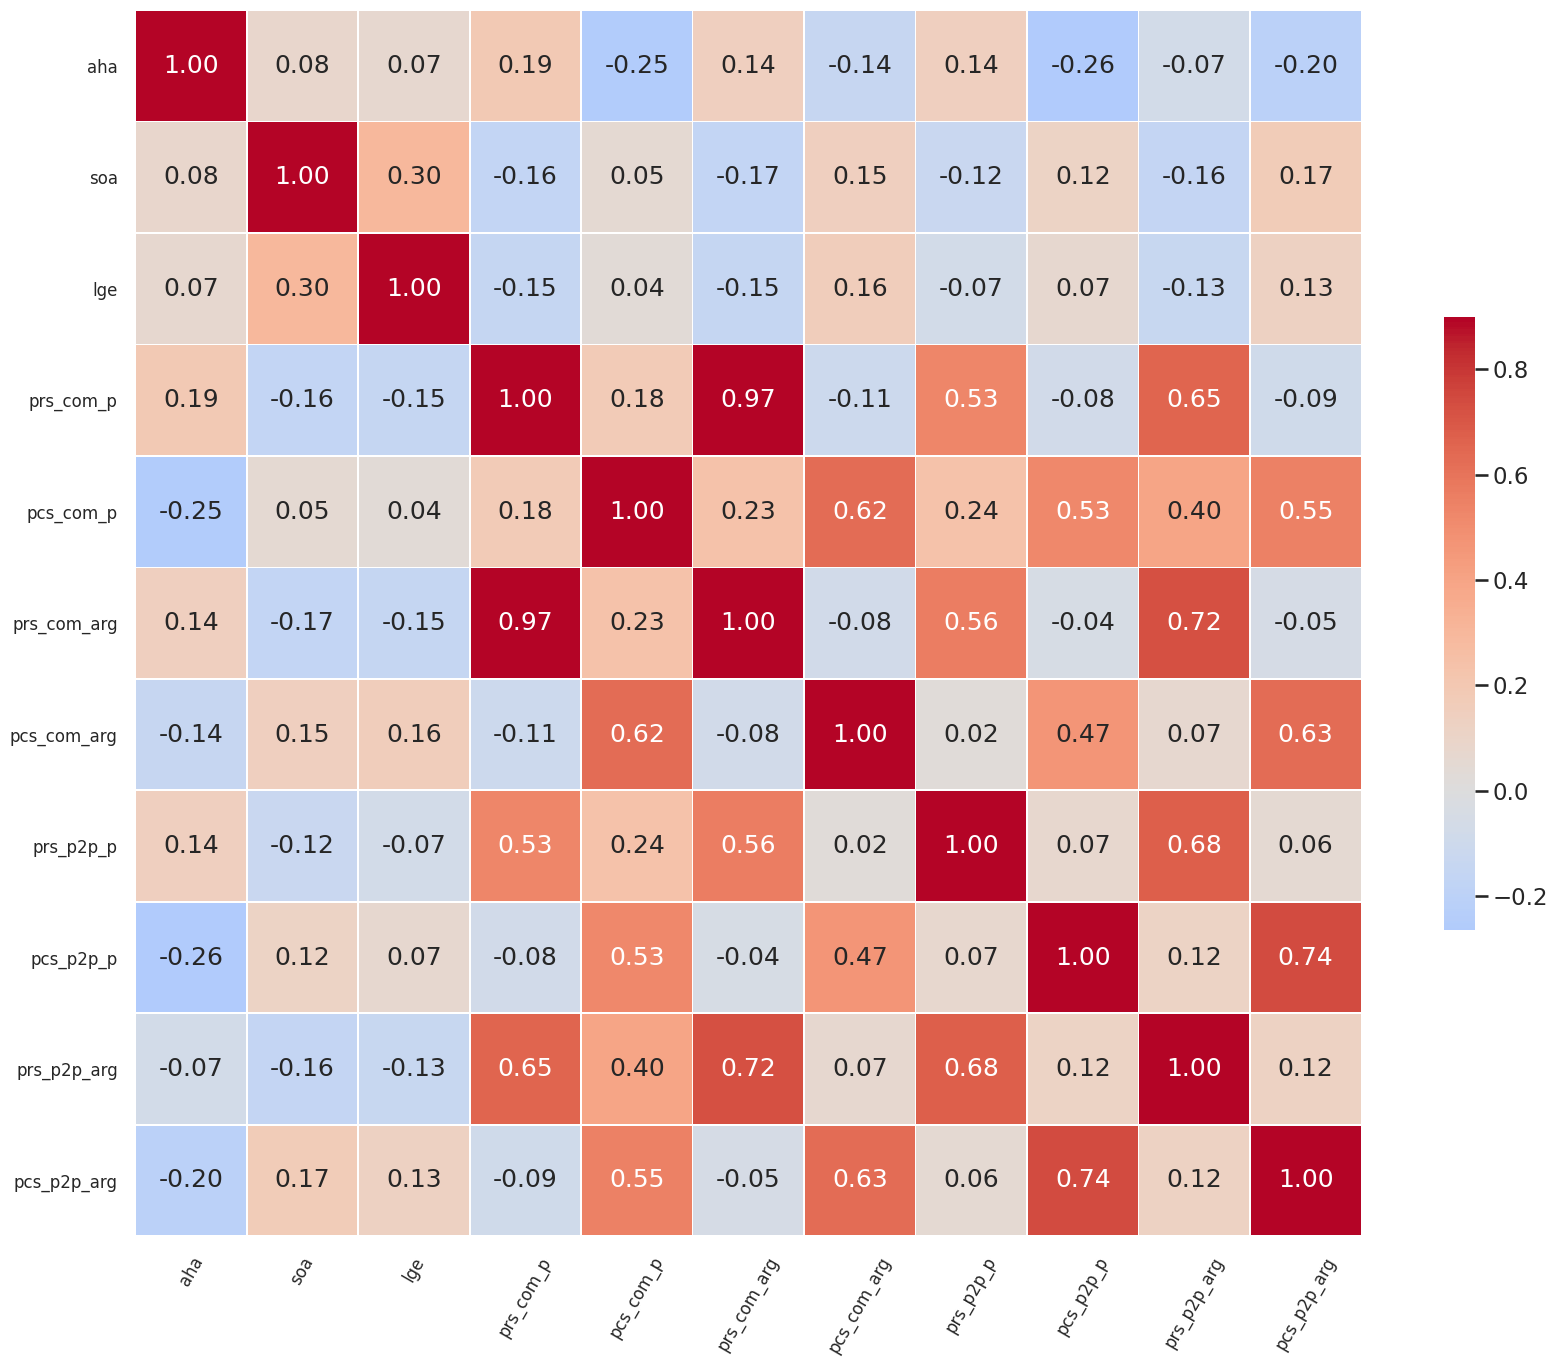

In [26]:
fig, ax = plt.subplots(figsize=(18,14)) 
corr = df_peak.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()
plt.show()

# Strain per phase

Extract one feature Vector per Patient (56 patients times 16 segments times 5 phases times two feature (rs, cs))

- 32 LGE positive patients
- 24 LGE negative patients

## Strain per patient from composed df (56 x 16 x 5 x 2) --> 56, 160

(57, 80)
(57, 160)
(57,)
(57,)
********** Logistic Regression **********
[0.42857143 0.71428571 0.66666667 0.5        0.71428571]
F1: 0.65 (+/- 0.13) [Logistic Regression]
Recall: 0.60 (+/- 0.12) [Logistic Regression]
Accuracy: 0.64 (+/- 0.13) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.85714286 0.66666667 1.         0.85714286]
F1: 0.73 (+/- 0.10) [Random Forest]
Recall: 0.82 (+/- 0.12) [Random Forest]
Accuracy: 0.62 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[0.57142857 0.57142857 0.33333333 0.83333333 0.71428571]
F1: 0.63 (+/- 0.16) [naive Bayes]
Recall: 0.60 (+/- 0.17) [naive Bayes]
Accuracy: 0.59 (+/- 0.16) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.42857143 0.16666667 0.66666667 0.57142857]
F1: 0.47 (+/- 0.16) [scaled DecissionTree]
Recall: 0.45 (+/- 0.17) [scaled DecissionTree]
Accuracy: 0.44 (+/- 0.13) [scaled DecissionTree]
********** KNN **********
[0.71428571 0.28571429 0.66666667 1.         0.28571429

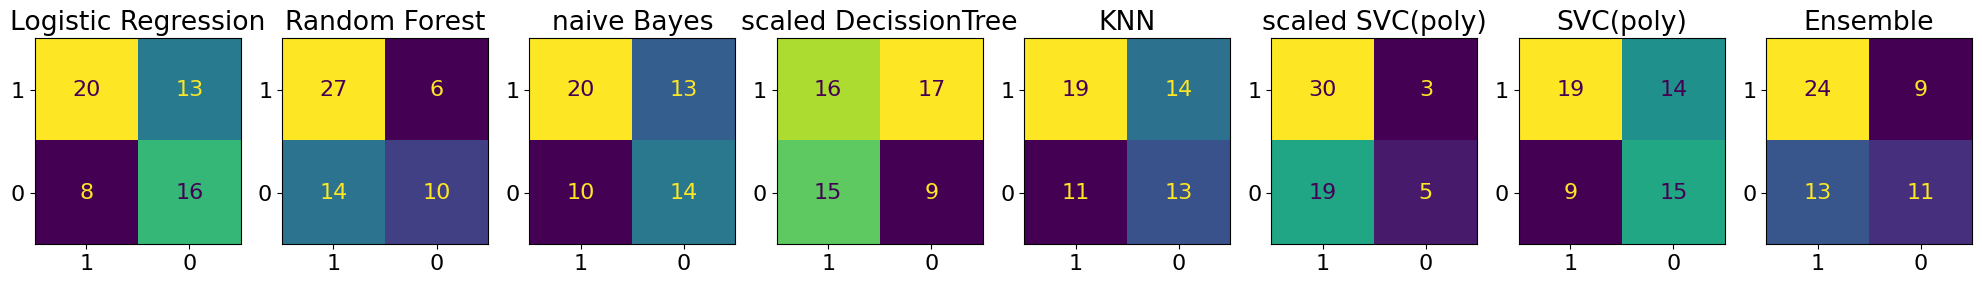

In [10]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.sort_values(['pat']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.sort_values(['pat']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain per patient from p2p df (56 x 16 x 5 x 2) --> 56, 160

(57, 80)
(57, 160)
(57,)
(57,)
********** Logistic Regression **********
[0.85714286 0.57142857 0.66666667 1.         0.71428571]
F1: 0.72 (+/- 0.10) [Logistic Regression]
Recall: 0.76 (+/- 0.15) [Logistic Regression]
Accuracy: 0.65 (+/- 0.11) [Logistic Regression]
********** Random Forest **********
[0.85714286 0.42857143 0.83333333 1.         0.85714286]
F1: 0.69 (+/- 0.16) [Random Forest]
Recall: 0.80 (+/- 0.19) [Random Forest]
Accuracy: 0.55 (+/- 0.20) [Random Forest]
********** naive Bayes **********
[0.71428571 0.28571429 0.5        0.83333333 0.28571429]
F1: 0.50 (+/- 0.16) [naive Bayes]
Recall: 0.52 (+/- 0.22) [naive Bayes]
Accuracy: 0.44 (+/- 0.16) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.71428571 0.66666667 0.66666667 0.57142857]
F1: 0.64 (+/- 0.06) [scaled DecissionTree]
Recall: 0.64 (+/- 0.06) [scaled DecissionTree]
Accuracy: 0.57 (+/- 0.11) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.28571429 0.16666667 0.5        0.28571429

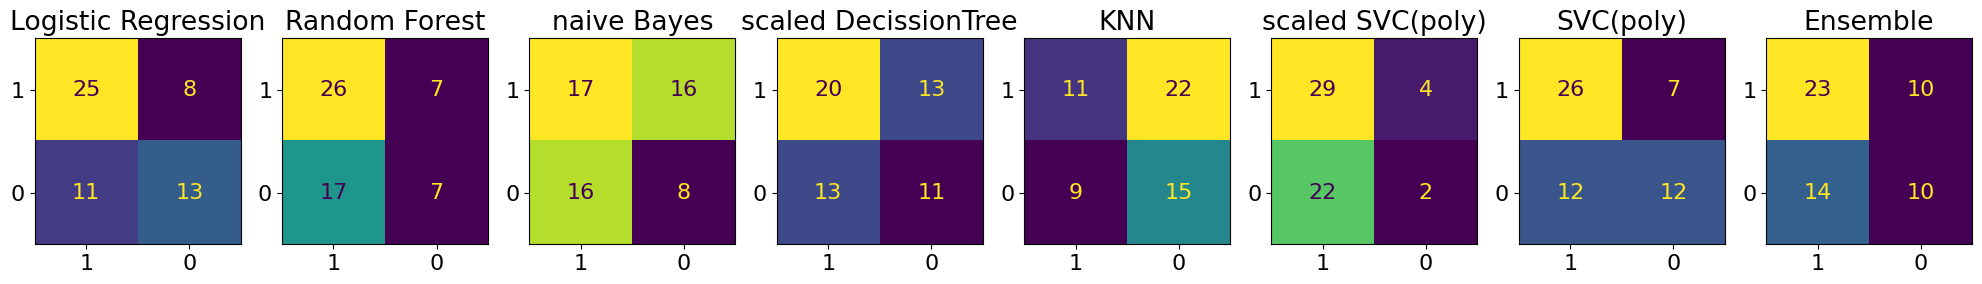

In [11]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_p2p.sort_values(['pat']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_p2p.sort_values(['pat']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_strain_p2p.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain per patient from p2p & composed df (56 x 16 x 5 x 2 x 2) --> 56, 320

# Peak Strain

- p2p
cs x 16 segments x 5 phases (80) & rs x 16 segments x 5 phases (80) --> 160 features per patient

- ed2p
cs x 16 segments x 5 phases (80) & rs x 16 segments x 5 phases (80) --> 160 features per patient

--> 320 features per patient

(57, 80)
(57, 320)
(57,)
(57,)
********** Logistic Regression **********
[0.57142857 0.85714286 0.83333333 0.66666667 0.85714286]
F1: 0.73 (+/- 0.08) [Logistic Regression]
Recall: 0.76 (+/- 0.12) [Logistic Regression]
Accuracy: 0.67 (+/- 0.08) [Logistic Regression]
********** Random Forest **********
[0.85714286 0.71428571 0.83333333 1.         0.85714286]
F1: 0.74 (+/- 0.08) [Random Forest]
Recall: 0.85 (+/- 0.09) [Random Forest]
Accuracy: 0.62 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[0.71428571 0.28571429 0.5        0.83333333 0.57142857]
F1: 0.59 (+/- 0.15) [naive Bayes]
Recall: 0.58 (+/- 0.19) [naive Bayes]
Accuracy: 0.55 (+/- 0.14) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.71428571 0.5        0.66666667 0.71428571]
F1: 0.58 (+/- 0.10) [scaled DecissionTree]
Recall: 0.60 (+/- 0.12) [scaled DecissionTree]
Accuracy: 0.47 (+/- 0.10) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.57142857 0.16666667 0.33333333 0.42857143

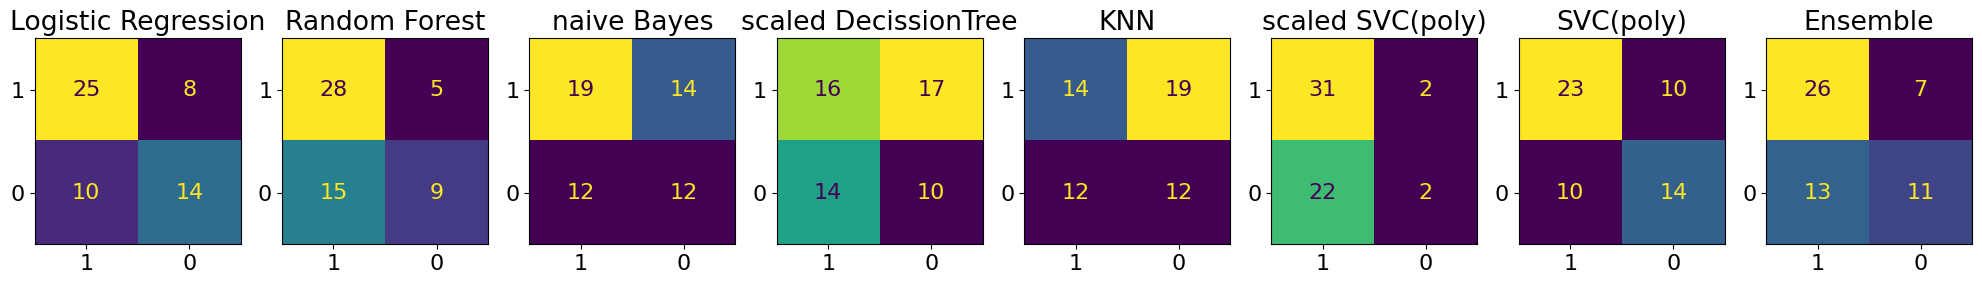

In [12]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.sort_values(['pat']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.sort_values(['pat']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc_p = np.stack(df_strain_p2p.sort_values(['pat']).groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr_p = np.stack(df_strain_p2p.sort_values(['pat']).groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr, xc_p, xr_p], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_strain_p2p.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (Phase) per patient from composed df

(57, 16)
(57, 32)
(57,)
(57,)
********** Logistic Regression **********
[0.71428571 0.85714286 0.83333333 0.83333333 0.71428571]
F1: 0.76 (+/- 0.05) [Logistic Regression]
Recall: 0.79 (+/- 0.06) [Logistic Regression]
Accuracy: 0.71 (+/- 0.07) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.85714286 1.         1.         0.42857143]
F1: 0.68 (+/- 0.12) [Random Forest]
Recall: 0.80 (+/- 0.21) [Random Forest]
Accuracy: 0.55 (+/- 0.13) [Random Forest]
********** naive Bayes **********
[0.71428571 0.71428571 1.         0.5        0.28571429]
F1: 0.64 (+/- 0.18) [naive Bayes]
Recall: 0.64 (+/- 0.24) [naive Bayes]
Accuracy: 0.59 (+/- 0.20) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.57142857 0.5        0.66666667 0.28571429]
F1: 0.55 (+/- 0.13) [scaled DecissionTree]
Recall: 0.52 (+/- 0.13) [scaled DecissionTree]
Accuracy: 0.51 (+/- 0.14) [scaled DecissionTree]
********** KNN **********
[0.28571429 0.71428571 0.5        0.83333333 0.28571429]

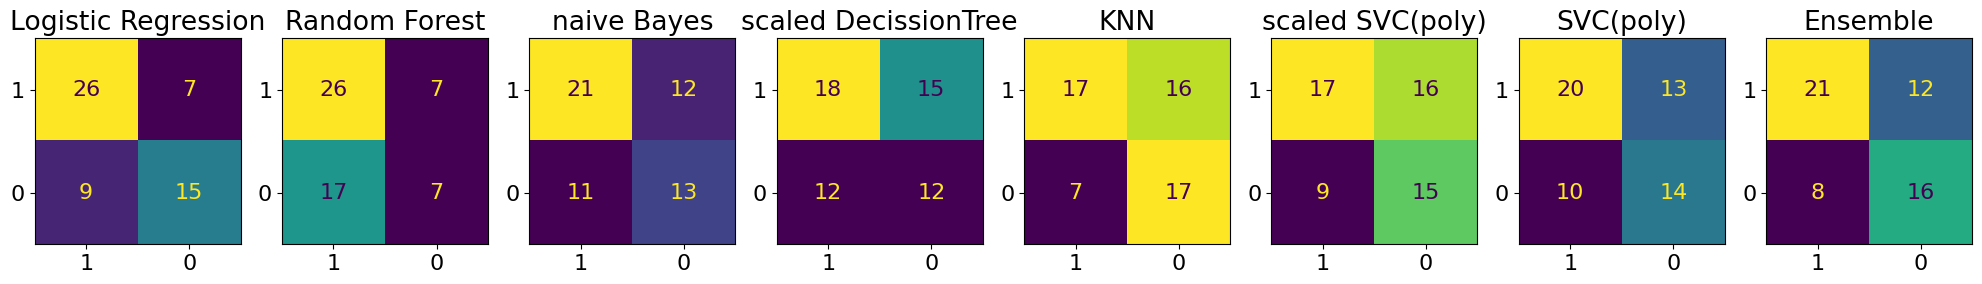

In [13]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (arg-min/max) per patient from composed df

(57, 16)
(57, 32)
(57,)
(57,)
********** Logistic Regression **********
[0.71428571 0.85714286 0.83333333 0.83333333 0.71428571]
F1: 0.75 (+/- 0.07) [Logistic Regression]
Recall: 0.79 (+/- 0.06) [Logistic Regression]
Accuracy: 0.68 (+/- 0.12) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.85714286 1.         1.         0.42857143]
F1: 0.67 (+/- 0.09) [Random Forest]
Recall: 0.77 (+/- 0.23) [Random Forest]
Accuracy: 0.58 (+/- 0.05) [Random Forest]
********** naive Bayes **********
[0.71428571 0.71428571 0.66666667 0.33333333 0.14285714]
F1: 0.55 (+/- 0.22) [naive Bayes]
Recall: 0.51 (+/- 0.23) [naive Bayes]
Accuracy: 0.57 (+/- 0.17) [naive Bayes]
********** scaled DecissionTree **********
[0.14285714 0.57142857 0.5        0.5        0.42857143]
F1: 0.42 (+/- 0.11) [scaled DecissionTree]
Recall: 0.43 (+/- 0.15) [scaled DecissionTree]
Accuracy: 0.33 (+/- 0.08) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.28571429 0.66666667 0.33333333 0.57142857]

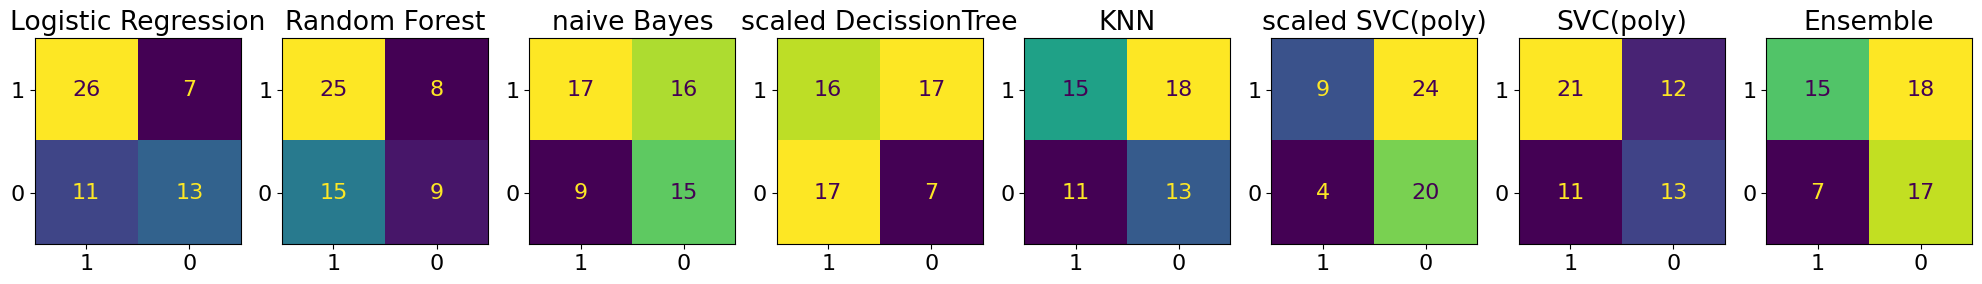

In [14]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (Phase) per patient from p2p df

(57, 16)
(57, 32)
(57,)
(57,)
********** Logistic Regression **********
[0.57142857 0.71428571 0.83333333 0.83333333 0.42857143]
F1: 0.70 (+/- 0.06) [Logistic Regression]
Recall: 0.68 (+/- 0.16) [Logistic Regression]
Accuracy: 0.70 (+/- 0.05) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.71428571 1.         1.         0.57142857]
F1: 0.72 (+/- 0.08) [Random Forest]
Recall: 0.77 (+/- 0.19) [Random Forest]
Accuracy: 0.66 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[0.57142857 0.42857143 0.83333333 1.         0.42857143]
F1: 0.63 (+/- 0.11) [naive Bayes]
Recall: 0.65 (+/- 0.23) [naive Bayes]
Accuracy: 0.58 (+/- 0.08) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.71428571 0.83333333 0.83333333 0.42857143]
F1: 0.64 (+/- 0.10) [scaled DecissionTree]
Recall: 0.68 (+/- 0.16) [scaled DecissionTree]
Accuracy: 0.54 (+/- 0.13) [scaled DecissionTree]
********** KNN **********
[0.28571429 0.28571429 0.33333333 0.16666667 0.28571429]

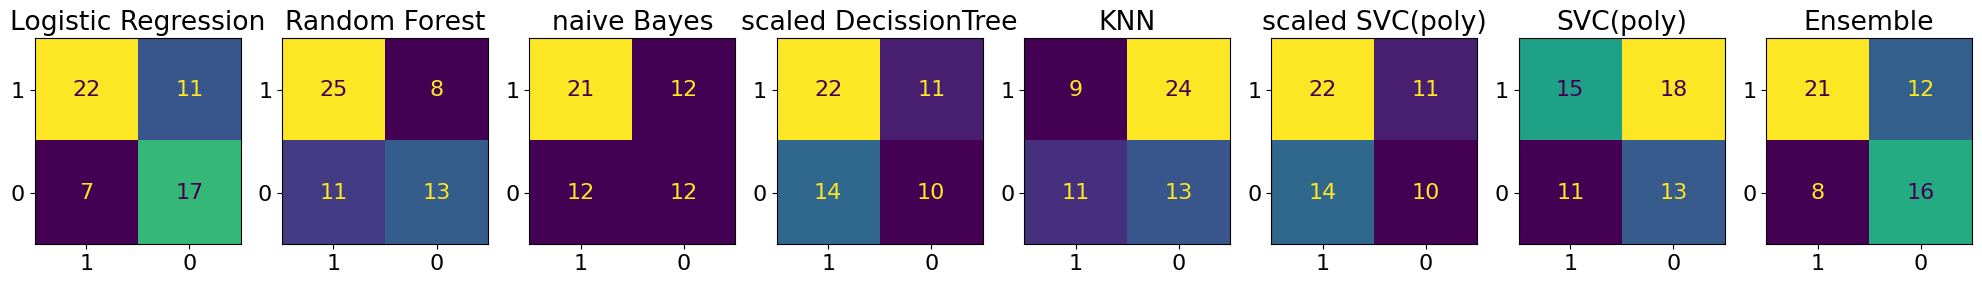

In [15]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## !!! Strain (arg-min/max) per patient from p2p df

works best for mid-cavity-segments

(57, 16)
(57, 32)
(57,)
(57,)
********** Logistic Regression **********
[0.28571429 0.71428571 1.         0.5        0.28571429]
F1: 0.57 (+/- 0.15) [Logistic Regression]
Recall: 0.56 (+/- 0.27) [Logistic Regression]
Accuracy: 0.59 (+/- 0.06) [Logistic Regression]
********** Random Forest **********
[0.85714286 0.85714286 0.83333333 1.         0.71428571]
F1: 0.76 (+/- 0.07) [Random Forest]
Recall: 0.85 (+/- 0.09) [Random Forest]
Accuracy: 0.66 (+/- 0.10) [Random Forest]
********** naive Bayes **********
[0.42857143 0.85714286 0.66666667 0.83333333 0.28571429]
F1: 0.60 (+/- 0.17) [naive Bayes]
Recall: 0.61 (+/- 0.22) [naive Bayes]
Accuracy: 0.54 (+/- 0.18) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.57142857 0.5        0.66666667 0.42857143]
F1: 0.56 (+/- 0.12) [scaled DecissionTree]
Recall: 0.52 (+/- 0.09) [scaled DecissionTree]
Accuracy: 0.50 (+/- 0.20) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.71428571 0.5        0.83333333 0.28571429]

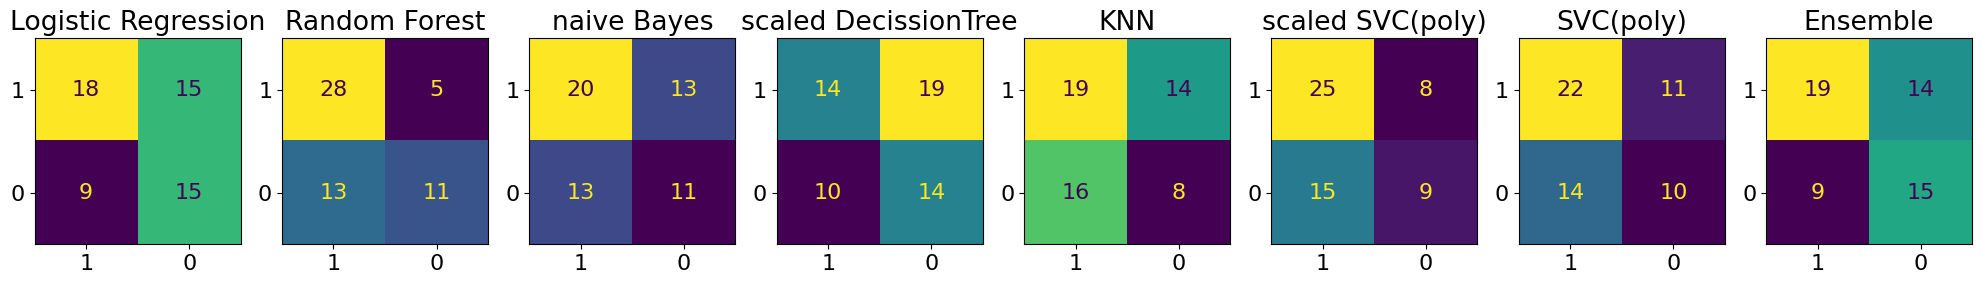

In [16]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## (Most robust) Strains concatenatet per patient

(57, 16)
(57, 128)
(57,)
(57,)
********** Logistic Regression **********
[0.85714286 0.57142857 0.66666667 0.83333333 0.57142857]
F1: 0.72 (+/- 0.07) [Logistic Regression]
Recall: 0.70 (+/- 0.12) [Logistic Regression]
Accuracy: 0.68 (+/- 0.07) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.71428571 0.5        1.         1.        ]
F1: 0.74 (+/- 0.11) [Random Forest]
Recall: 0.79 (+/- 0.19) [Random Forest]
Accuracy: 0.69 (+/- 0.10) [Random Forest]
********** naive Bayes **********
[0.57142857 0.57142857 0.83333333 0.66666667 0.57142857]
F1: 0.64 (+/- 0.05) [naive Bayes]
Recall: 0.64 (+/- 0.10) [naive Bayes]
Accuracy: 0.57 (+/- 0.07) [naive Bayes]
********** scaled DecissionTree **********
[0.71428571 1.         0.5        0.5        0.28571429]
F1: 0.61 (+/- 0.17) [scaled DecissionTree]
Recall: 0.60 (+/- 0.24) [scaled DecissionTree]
Accuracy: 0.59 (+/- 0.15) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.57142857 0.5        0.66666667 0.57142857

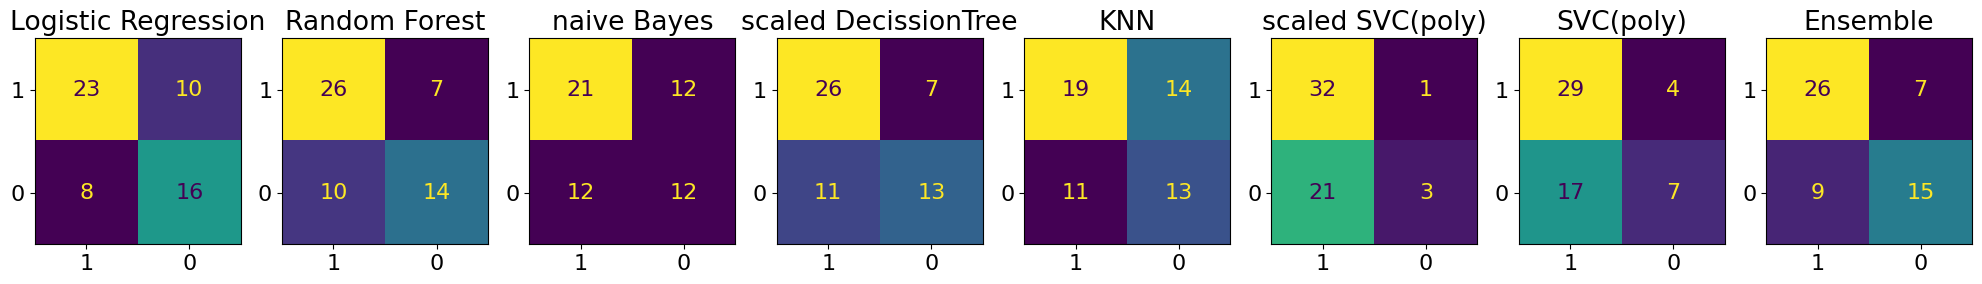

In [15]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc2 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr2 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc3 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr3 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc4 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['pcs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr4 = np.stack(df_peak.sort_values(['pat']).groupby(['pat'])['prs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr,xc2,xr2,xc3,xr3,xc4,xr4], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
#y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
#y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

# Strain per Segment

(912, 5)
(912, 10)
(912, 5)
(912,)
********** Logistic Regression **********
[0.65789474 0.76315789 0.59459459 0.51351351 0.72972973]
F1: 0.42 (+/- 0.03) [Logistic Regression]
Recall: 0.65 (+/- 0.09) [Logistic Regression]
Accuracy: 0.64 (+/- 0.03) [Logistic Regression]
********** Random Forest **********
[0.07894737 0.02631579 0.08108108 0.         0.08108108]
F1: 0.09 (+/- 0.06) [Random Forest]
Recall: 0.05 (+/- 0.03) [Random Forest]
Accuracy: 0.52 (+/- 0.02) [Random Forest]
********** naive Bayes **********
[0.63157895 0.47368421 0.40540541 0.48648649 0.67567568]
F1: 0.35 (+/- 0.01) [naive Bayes]
Recall: 0.53 (+/- 0.10) [naive Bayes]
Accuracy: 0.58 (+/- 0.01) [naive Bayes]
********** scaled DecissionTree **********
[0.31578947 0.28947368 0.18918919 0.2972973  0.40540541]
F1: 0.31 (+/- 0.05) [scaled DecissionTree]
Recall: 0.30 (+/- 0.07) [scaled DecissionTree]
Accuracy: 0.57 (+/- 0.02) [scaled DecissionTree]
********** KNN **********
[0.10526316 0.18421053 0.21621622 0.10810811 0.1351

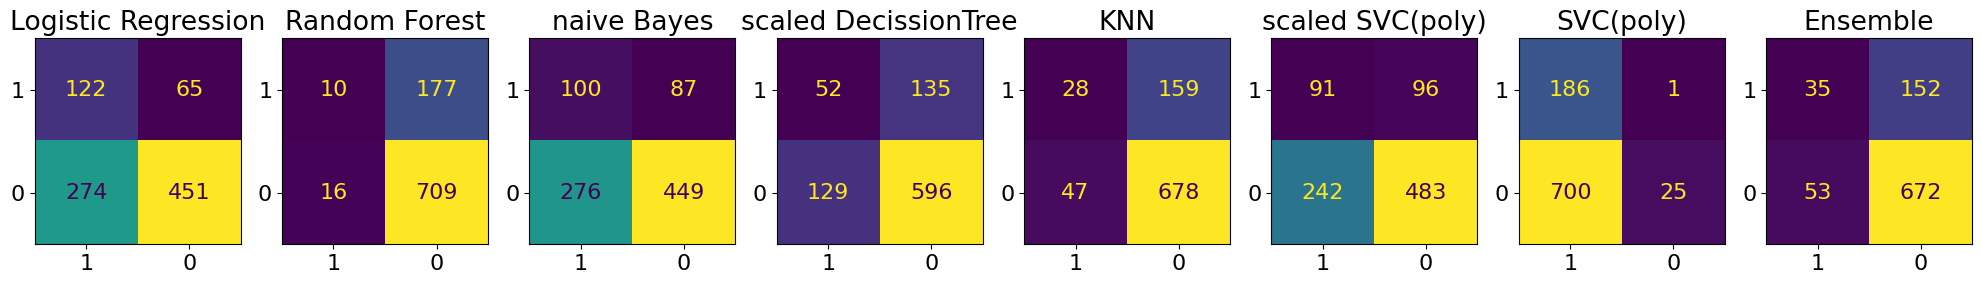

In [17]:
# per patient with peak values from the phases and argmax
# 56 patients x 16 segments = 896
# per segment we take the circumferential strain
xc = np.stack(df_strain_p2p.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_p2p.groupby(['pat','aha'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x_ = np.concatenate([xc,xr], axis=1)
print(x_.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y_ = np.stack(df_strain_comp.groupby(['pat','aha'])['lge'].apply(list).values).astype(np.float32)
print(y_.shape)
y_ = y_.sum(axis=1)>0
print(y_.shape)
cross_validate_f1(x_,y_)

In [44]:
# fit one model per segment
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
# iterate over the aha segments
# create a sub dataframe of PRS, PCS or comp, p2p
# with the shape: patients, features (56, 2 or 56,psp+com)
# extract x and y for this segment
estimators = []
preds = []
y_tests = []
patients = df_strain_p2p.pat.unique()
X_train, X_test, _, _ = train_test_split(
    patients, patients, test_size=0.2, random_state=42)
# iterate over the segments
for seg in df_strain_p2p.aha.unique():
    print("segment: {}".format(seg))
    # create a temp sub df for only the train patients
    df_strain_p2p_temp = df_strain_p2p[df_strain_p2p['pat'].isin(X_train)]
    df_strain_comp_temp = df_strain_comp[df_strain_comp['pat'].isin(X_train)]
    df_strain_p2p_test = df_strain_p2p[df_strain_p2p['pat'].isin(X_test)]
    df_strain_comp_test = df_strain_comp[df_strain_comp['pat'].isin(X_test)]
    
    # filter the current segment
    seg_of_interest= [seg]
    df_strain_p2p_temp = df_strain_p2p_temp[df_strain_p2p_temp['aha'].isin(seg_of_interest)]
    df_strain_comp_temp = df_strain_comp_temp[df_strain_comp_temp['aha'].isin(seg_of_interest)]
    df_strain_p2p_test = df_strain_p2p_test[df_strain_p2p_test['aha'].isin(seg_of_interest)]
    df_strain_comp_test = df_strain_comp_test[df_strain_comp_test['aha'].isin(seg_of_interest)]
    
    # 280,7 --> 56 patients x 5 phases = 280; and ['pat', 'aha', 'phase', 'our_rs', 'our_cs', 'soa', 'lge']
    cs_p2p = np.stack(df_strain_p2p_temp.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)
    cs_comp = np.stack(df_strain_comp_temp.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)
    x_ = cs_comp#np.concatenate([cs_p2p, cs_comp], axis=1)
    y_ = np.stack(df_strain_p2p_temp.groupby(['pat','aha'])['lge'].apply(list).values).astype(np.float32)
    y_ = y_.sum(axis=1)>0
    
    cs_p2p_test = np.stack(df_strain_p2p_test.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)
    cs_comp_test = np.stack(df_strain_comp_test.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)
    x_test = cs_comp_test#np.concatenate([cs_p2p_test, cs_comp_test], axis=1)
    y_test = np.stack(df_strain_p2p_test.groupby(['pat','aha'])['lge'].apply(list).values).astype(np.float32)
    y_test = y_test.sum(axis=1)>0
    if y_.sum()>4:
        clf_ = make_pipeline(MinMaxScaler(), DecisionTreeClassifier(class_weight='balanced'))
        clf_.fit(x_, y_)
        train_preds = clf_.predict(x_)
        estimators.append(('{}'.format(seg), clf_))
        pred_ = clf_.predict(x_test)
        preds.append(pred_)
        y_tests.append(y_test)
        print(accuracy_score(y_, train_preds))
        print(precision_score(y_, train_preds))
        print(accuracy_score(y_test, pred_))
        print(precision_score(y_test, pred_))
        #cross_validate_f1(x_,y_); plt.show()
    else:
        print('only {} pos examples, no splits possible'.format(y_.sum()))

segment: 1
only 1 pos examples, no splits possible
segment: 2
only 2 pos examples, no splits possible
segment: 3
only 2 pos examples, no splits possible
segment: 4
1.0
1.0
0.5833333333333334
0.5
segment: 5
1.0
1.0
0.5833333333333334
0.5714285714285714
segment: 6
1.0
1.0
0.5833333333333334
0.4
segment: 7
1.0
1.0
1.0
1.0
segment: 8
only 3 pos examples, no splits possible
segment: 9
only 4 pos examples, no splits possible
segment: 10
1.0
1.0
0.6666666666666666
0.6666666666666666
segment: 11
1.0
1.0
0.3333333333333333
0.2857142857142857
segment: 12
1.0
1.0
0.5
0.3333333333333333
segment: 13
1.0
1.0
0.75
0.3333333333333333
segment: 14
only 3 pos examples, no splits possible
segment: 15
1.0
1.0
0.75
0.0
segment: 16
1.0
1.0
0.5833333333333334
0.2


In [45]:
preds_stack = np.stack(preds, axis=0)
print(preds_stack.shape)
y_tests_stack = np.stack(y_tests, axis=0)
for p in range(y_tests_stack.shape[1]):
    print('--'*10)
    print(preds_stack[:,p].sum())
    print(y_tests_stack[:,p].sum())

(10, 12)
--------------------
2
0
--------------------
6
7
--------------------
2
4
--------------------
1
0
--------------------
3
0
--------------------
4
0
--------------------
6
0
--------------------
4
0
--------------------
6
8
--------------------
5
2
--------------------
2
5
--------------------
3
10


In [30]:
# check for nan and infinit values
x[~np.isfinite(x)]

NameError: name 'x' is not defined

# Unsupervised Clustering

In [46]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#temp_2d = TSNE(n_components=2, perplexity=4, learning_rate=50).fit_transform(x)
#temp_2d = PCA(n_components=2).fit_transform(x)
temp_2d = make_pipeline(
    #StandardScaler(),
    MinMaxScaler(),
    #NeighborhoodComponentsAnalysis(n_components=4, random_state=42),
    TSNE(n_components=2, perplexity=2, learning_rate=500, method='exact', init='pca')
    ).fit_transform(x)

/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(57, 3)


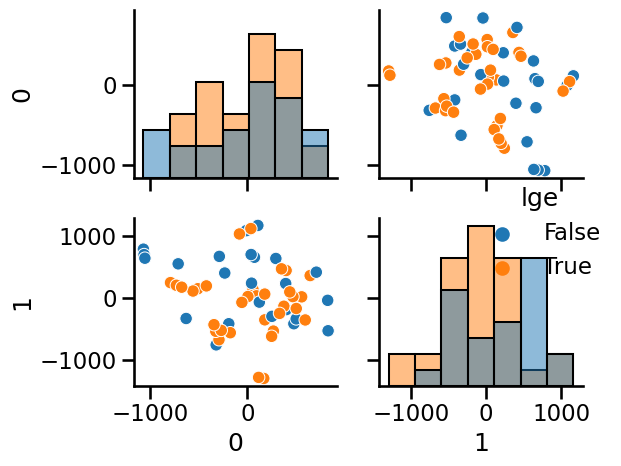

In [47]:
sb.set_context("talk")
df_temp = pd.DataFrame(temp_2d)
df_temp['lge'] = y
print(df_temp.shape)
g = sb.pairplot(data=df_temp,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

In [ ]:
cross_validate_f1(temp_2d,y)

********** Logistic Regression **********
[0.42857143 0.28571429 0.5        0.66666667 0.71428571]
Recall: 0.52 (+/- 0.16) [Logistic Regression]
Accuracy: 0.49 (+/- 0.13) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.57142857 0.33333333 1.         0.85714286]
Recall: 0.67 (+/- 0.24) [Random Forest]
Accuracy: 0.55 (+/- 0.16) [Random Forest]
********** naive Bayes **********
[0.85714286 0.57142857 0.83333333 1.         1.        ]
Recall: 0.85 (+/- 0.16) [naive Bayes]
Accuracy: 0.51 (+/- 0.08) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.57142857 0.5        1.         0.71428571]
Recall: 0.67 (+/- 0.18) [scaled DecissionTree]
Accuracy: 0.62 (+/- 0.08) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.28571429 0.16666667 0.66666667 0.42857143]
Recall: 0.40 (+/- 0.17) [KNN]
Accuracy: 0.49 (+/- 0.05) [KNN]
********** scaled SVC(poly) **********
[0.28571429 0.71428571 0.83333333 0.83333333 0.71428571]
Recall: 0.68 (+/- 0.20) [s

# Gridsearch for the best Estimator pipeline

In [153]:
# find the param names within a gridsearch
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'clf__C', 'clf__break_ties', 'clf__cache_size', 'clf__class_weight', 'clf__coef0', 'clf__decision_function_shape', 'clf__degree', 'clf__gamma', 'clf__kernel', 'clf__max_iter', 'clf__probability', 'clf__random_state', 'clf__shrinking', 'clf__tol', 'clf__verbose'])

In [ ]:
################ ensemble #############
clf1 = LogisticRegression(random_state=1, class_weight='balanced')
clf2 = RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')
clf3 = GaussianNB()
clf4 = tree.DecisionTreeClassifier(class_weight='balanced')
clf5 = make_pipeline(NeighborhoodComponentsAnalysis(random_state=42, n_components=2), KNeighborsClassifier(n_neighbors=2))
clf6 = SVC(kernel='poly',gamma='auto',class_weight='balanced', C=1, degree=3)
clf7 = SVC(kernel='poly', gamma='auto',class_weight='balanced')

eclf = VotingClassifier(
    estimators=[
        ('lr', clf1), 
        ('rf', clf2), 
        ('svc', clf6),
        ('dt', clf4)
               ],
    voting='hard')
eclf.get_params().keys()

                  'clf__lr__class_weight':weights,
                 'clf__lr__penalty':penalties,
                  'clf__rf_n_estimators':n_estimators,
                 'clf__rf__class_weight':weights,
                  'clf__svc__gamma': gammas, 
                  'clf__svc__C': Cs, 
                  'clf__svc__kernel': kernels, 
                  'clf__svc__class_weight':weights,
                  'clf__dt__class_weight':weights,

In [9]:

def create_grid_search():
    gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 'scale', 'auto']
    Cs = [0.1, 1, 10, 100, 1e3, 1e4, 1e5]
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    weights = [None, 'balanced']
    degree = [2,3,4,5]
    n_estimators = [10,100,500,1000]

    penalties = ['l2']
    solvers = ['liblinear']

    scaler = [StandardScaler(), MinMaxScaler(), None]
    
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)

    [ 
     'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 
     'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 
     'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 
     'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose']

    svc_params = {'clf':(SVC(),), 
                  'clf__gamma': gammas, 
                  'clf__C': Cs, 
                  'clf__kernel': kernels, 
                  'clf__class_weight':weights,
                 'scaler': scaler}
    
    ################ ensemble #############
    clf1 = LogisticRegression(random_state=1, class_weight='balanced', penalty='l2',)
    clf2 = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf4 = tree.DecisionTreeClassifier(class_weight='balanced')
    clf6 = SVC(kernel='poly',gamma='scale',class_weight='balanced', C=1, degree=3)
    
    eclf = VotingClassifier(
        estimators=[
            ('lr', clf1), 
            ('rf', clf2), 
            ('dt', clf4),
            ('svc', clf6)
                   ],
        voting='hard')
    
    ens_params = {'clf':(eclf,),
                 'scaler': scaler}
    
    
    rf_params = {'clf':(RandomForestClassifier( random_state=1, class_weight='balanced'),),
                'clf__n_estimators':n_estimators,
                 'clf__class_weight':weights,
                'scaler': scaler}
    lr_params = {'clf':(LogisticRegression(random_state=1, max_iter=10000,class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__penalty':penalties,
                 'clf__C': Cs,
                 'clf__solver': solvers,
                'scaler': scaler}
    et_params = {'clf': (ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1),),
                 'clf__n_estimators':n_estimators,
                'scaler': scaler}
    params = [rf_params, svc_params, lr_params, et_params, ens_params]


    pipeline = Pipeline( steps=[
        ('scaler',StandardScaler()), 
        ('clf', SVC())
    ])
    return GridSearchCV(estimator=pipeline, 
                        param_grid=params, 
                        scoring=['recall', 'accuracy', 'balanced_accuracy', 'average_precision','precision', 'f1'], 
                        refit='f1',
                        cv=skf,
                        n_jobs=16)
gs = create_grid_search()
gs = gs.fit(x, y)

/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/met

In [10]:
results = pd.DataFrame.from_dict(gs.cv_results_)
results["params_str"] = results.params.apply(str)
pd.set_option('display.max_colwidth', None)
results.shape

(1593, 63)

In [11]:
results.sort_values(by=['rank_test_f1','rank_test_accuracy','rank_test_recall'])[['mean_test_f1','mean_test_recall', 'mean_test_accuracy', 'params_str']].head(5)

mean_test_f1  mean_test_recall  mean_test_accuracy  \
368       0.838095          0.914286            0.790909   
29        0.827473          0.914286            0.772727   
689       0.827473          0.914286            0.772727   
1349      0.827473          0.914286            0.772727   
332       0.827074          0.885714            0.772727   

                                                                                                                                                             params_str  
368      {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}  
29           {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 0.1, 'clf__class_weight': None, 'clf__gamma': 0.1, 'clf__kernel': 'poly', 'scaler': None}  
689         {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 100, 'clf__class_weight': None, 'clf__gamma': 0.01, 'clf__kernel': 'poly', 'scaler': None}  
1349  {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 100000.0, 'clf__class_weight': None, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'scaler': None}  
332         {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 1, 'clf__class_weight': None, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'scaler': None}

In [12]:
results.sort_values(by=['rank_test_balanced_accuracy', 'rank_test_recall','rank_test_f1'])[['mean_test_f1','mean_test_recall', 'mean_test_accuracy', 'params_str']].head(5)

mean_test_f1  mean_test_recall  mean_test_accuracy  \
368       0.838095          0.914286            0.790909   
476       0.811282          0.823810            0.771212   
932       0.816044          0.852381            0.771212   
1160      0.816044          0.852381            0.771212   
1388      0.816044          0.852381            0.771212   

                                                                                                                                                            params_str  
368     {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}  
476          {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 10, 'clf__class_weight': None, 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}  
932    {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 1000.0, 'clf__class_weight': None, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'scaler': None}  
1160   {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 10000.0, 'clf__class_weight': None, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'scaler': None}  
1388  {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 100000.0, 'clf__class_weight': None, 'clf__gamma': 1e-06, 'clf__kernel': 'rbf', 'scaler': None}

## Evaluate best estimators from gridsearch CV

**Recall** in this context is also referred to as the true positive rate or sensitivity, and 

$\frac{tp}{tp+fn}$ 



**Precision** is also referred to as positive predictive value (PPV); other related measures used in classification include true negative rate and accuracy. True negative rate is also called specificity.

$\frac{tp}{tp+fp)}$



**Accuracy** (maybe missleading for imbalanced data.)

$\frac{tp+tn}{tp+tn+fp+fn}$



params: {'clf': SVC(C=1, class_weight='balanced', gamma=0.01), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}
[0.85714286 0.71428571 1.         1.         1.        ]
Recall: 0.91 (+/- 0.11) []
Accuracy: 0.79 (+/- 0.13) []
Precision: 0.80 (+/- 0.17) []
Balanced Accuracy: 0.78 (+/- 0.15) []
F1: 0.84 (+/- 0.09) []
AUC: 0.77


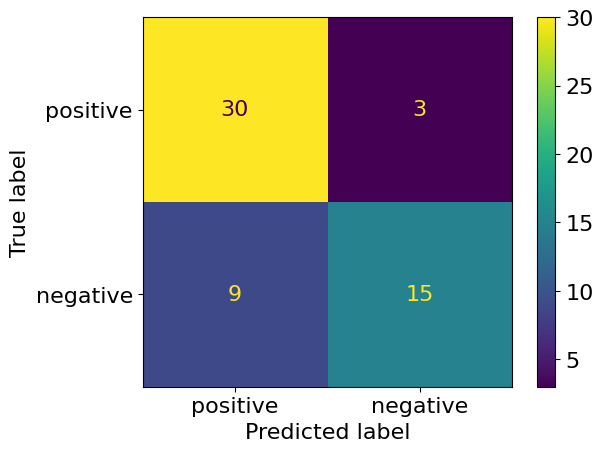

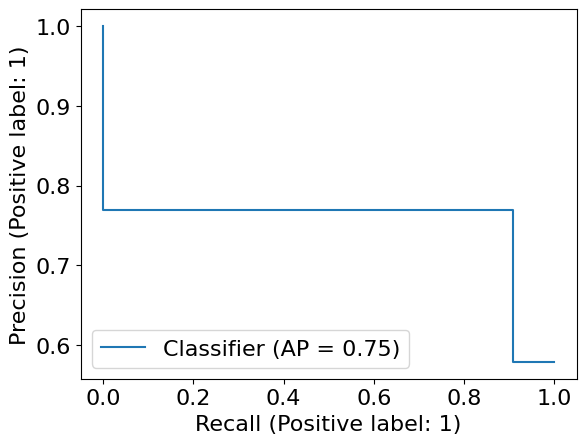

In [13]:
def plot_report(clf, x, y, label=''):
    from sklearn.metrics import (precision_recall_curve,
                                 PrecisionRecallDisplay)
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)
    y_pred = cross_val_predict(clf, x, y, cv=skf)
    scores = cross_validate(clf, x, y, scoring=['recall', 'accuracy', 'balanced_accuracy', 'precision', 'f1'], cv=skf)
    print('params: {}'.format(label))
    print(scores['test_recall'])
    print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), ""))
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std(), ""))
    print("Precision: %0.2f (+/- %0.2f) [%s]" % (scores['test_precision'].mean(), scores['test_precision'].std(), ""))
    print("Balanced Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_balanced_accuracy'].mean(), scores['test_balanced_accuracy'].std(), ""))
    print("F1: %0.2f (+/- %0.2f) [%s]" % (scores['test_f1'].mean(), scores['test_f1'].std(), ""))
    print('AUC: {:.2f}'.format(sklearn.metrics.roc_auc_score(y,y_pred)))
    disp = ConfusionMatrixDisplay.from_predictions(y, y_pred,labels=[1,0], display_labels=['positive','negative'],colorbar=True)
    disp = PrecisionRecallDisplay.from_predictions(y,y_pred)
    
plot_report(gs.best_estimator_, x, y, label=gs.best_params_)
plt.show()

In [49]:
print(gs.best_params_)
gs.best_estimator_

{'clf': LogisticRegression(C=1, max_iter=10000, random_state=1, solver='liblinear'), 'clf__C': 1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'scaler': None}


Pipeline(steps=[('scaler', None),
                ('clf',
                 LogisticRegression(C=1, max_iter=10000, random_state=1,
                                    solver='liblinear'))])

params: [('scaler', StandardScaler()), ('clf', RandomForestClassifier(class_weight='balanced', random_state=1))]
[0.57142857 1.         0.66666667 1.         0.71428571]
Recall: 0.79 (+/- 0.18) []
Accuracy: 0.68 (+/- 0.14) []
Precision: 0.70 (+/- 0.10) []
Balanced Accuracy: 0.67 (+/- 0.14) []
F1: 0.74 (+/- 0.12) []
AUC: 0.66


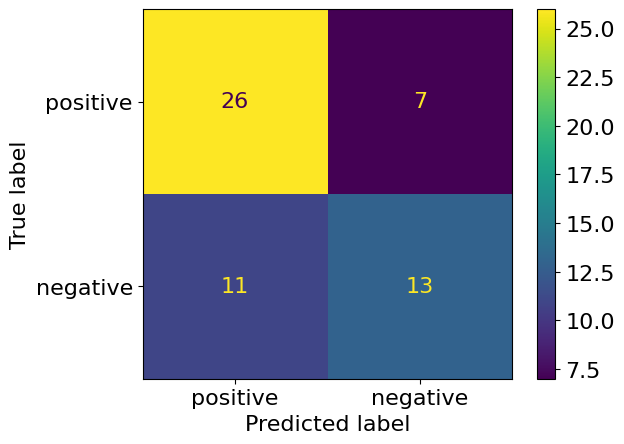

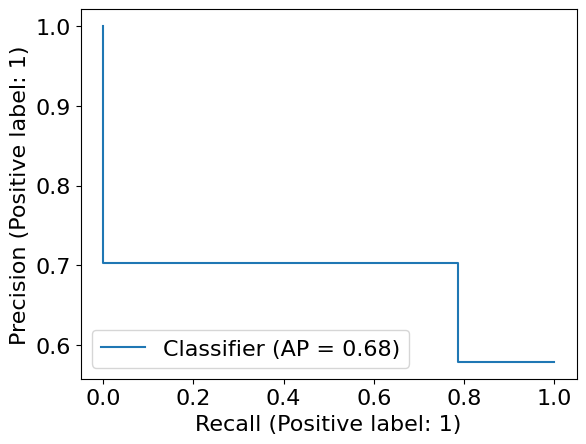

In [70]:
# Best pipeline according to the balanced accuracy
#{'clf': SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='sigmoid'), 'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'sigmoid', 'scaler': StandardScaler()}
# RandomForestClassifier(class_weight='balanced', random_state=1)
best_clf = Pipeline(steps=[('scaler',StandardScaler()),('clf',RandomForestClassifier(class_weight='balanced', random_state=1))])
plot_report(best_clf, x, y, label=best_clf.get_params()['steps']);plt.show()

params: [('scaler', StandardScaler()), ('clf', SVC(C=10, gamma=0.01, kernel='poly'))]
[1. 1. 1. 1. 1.]
Recall: 1.00 (+/- 0.00) []
Accuracy: 0.57 (+/- 0.04) []
Precision: 0.57 (+/- 0.04) []
Balanced Accuracy: 0.50 (+/- 0.00) []
F1: 0.73 (+/- 0.03) []
AUC: 0.50


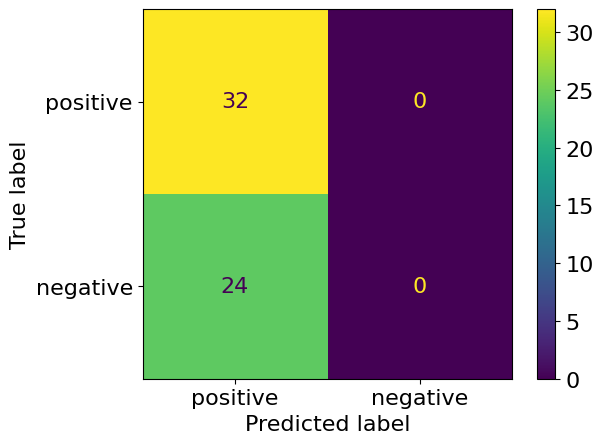

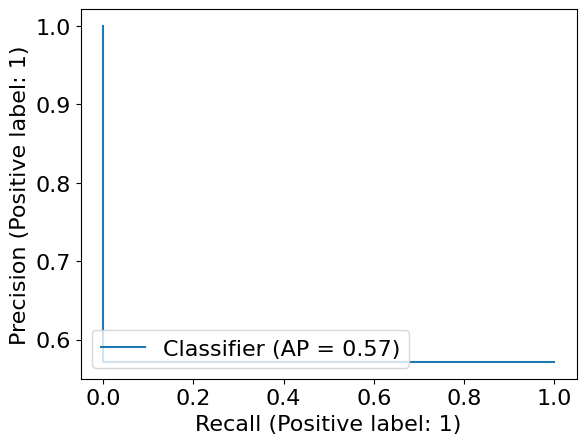

In [34]:
# this one has the highest recall == 1, but no real information gain
best_clf = Pipeline(steps=[('scaler',StandardScaler(),),('clf',SVC(C=10, class_weight=None, gamma=0.01, kernel='poly'),)])
plot_report(best_clf, x, y, label=best_clf.get_params()['steps']);plt.show()

params: [('standardscaler', StandardScaler()), ('svc', SVC(C=1, class_weight='balanced', kernel='linear'))]
[0.57142857 0.83333333 0.66666667 0.5        0.85714286]
Recall: 0.69 (+/- 0.14) []
Accuracy: 0.68 (+/- 0.14) []
Precision: 0.75 (+/- 0.17) []
Balanced Accuracy: 0.68 (+/- 0.14) []
F1: 0.71 (+/- 0.13) []
AUC: 0.68


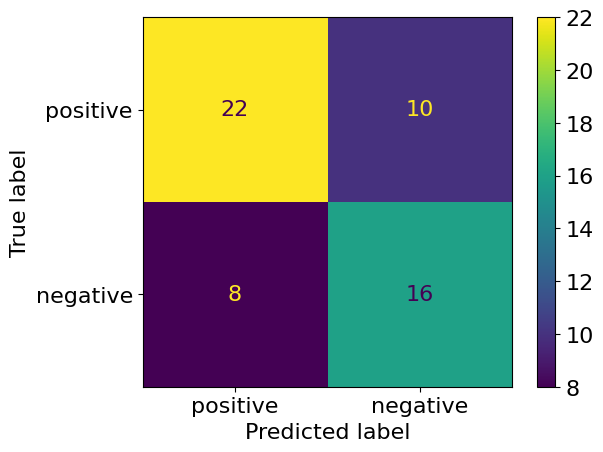

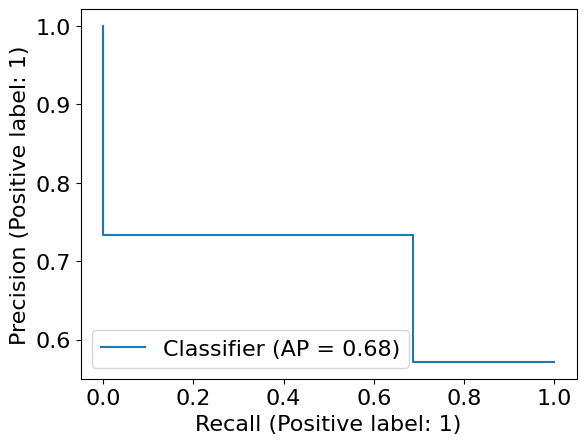

In [35]:
# this one has a high recall, but still a valid accuracy
best_clf = make_pipeline(StandardScaler(), SVC(kernel='linear',gamma='scale',class_weight='balanced', C=1, degree=3))
plot_report(best_clf, x, y, label=best_clf.get_params()['steps']);plt.show()

params: [('standardscaler', StandardScaler()), ('svc', SVC(C=1, class_weight='balanced', kernel='linear'))]
[0.57142857 0.83333333 0.66666667 0.5        0.85714286]
Recall: 0.69 (+/- 0.14) []
Accuracy: 0.68 (+/- 0.14) []
Precision: 0.75 (+/- 0.17) []
Balanced Accuracy: 0.68 (+/- 0.14) []
F1: 0.71 (+/- 0.13) []
AUC: 0.68


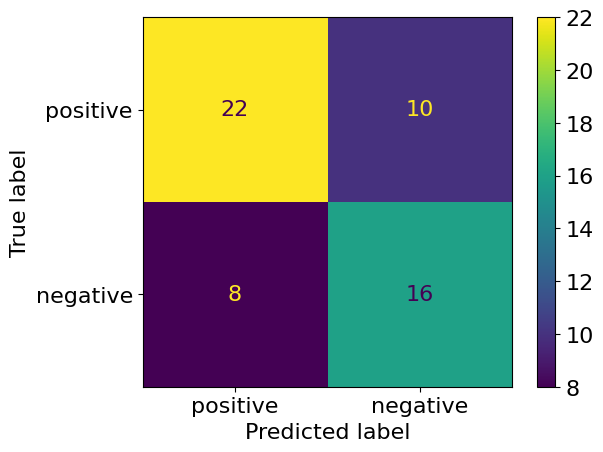

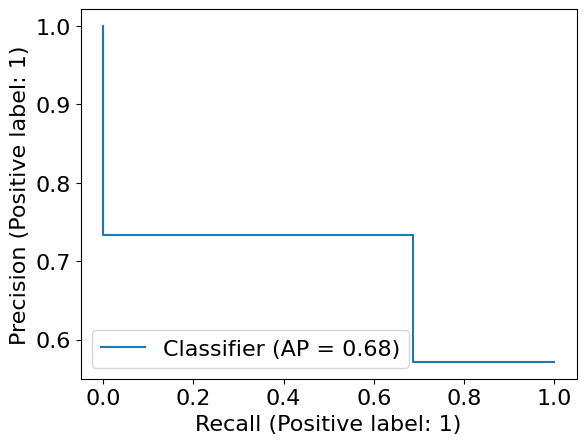

In [36]:
plot_report(best_clf, x, y, label=best_clf.get_params()['steps']);plt.show()

# Model Essemble according to different metrics

In [32]:
# best balanced accuracy
results.sort_values(by='rank_test_balanced_accuracy', inplace=True, ascending=True)
params_best_ba = results.head(1)['params'].values[0]
print(params_best_ba)
clf_best_ba = gs.best_estimator_.set_params(**params_best_ba)
clf_best_ba

{'clf': SVC(C=100000.0, gamma=0.0001), 'clf__C': 100000.0, 'clf__class_weight': None, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'scaler': None}


Pipeline(steps=[('scaler', None), ('clf', SVC(C=100000.0, gamma=0.0001))])

In [33]:
# best f1
results.sort_values(by='rank_test_f1', inplace=True,ascending=True)
params_best_f1 = results.head(1)['params'].values[0]
print(params_best_f1)
clf_best_f1 = gs.best_estimator_.set_params(**params_best_f1)

{'clf': SVC(C=100000.0, gamma=0.0001), 'clf__C': 100000.0, 'clf__class_weight': None, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'scaler': None}


In [34]:
# best average precision
results.sort_values(by='rank_test_precision', inplace=True,ascending=True)
params_best_ap = results.head(1)['params'].values[0]
print(params_best_ap)
clf_best_ap = gs.best_estimator_.set_params(**params_best_ap)

{'clf': SVC(C=100000.0, gamma=0.0001), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'poly', 'scaler': MinMaxScaler()}


In [35]:
eclf = VotingClassifier(
        estimators=[
            ('ba', clf_best_ba), 
            ('f1', clf_best_f1),
            ('ap', clf_best_ap)
                   ],
        voting='hard')

params: ensamble
[0.28571429 1.         0.33333333 0.33333333 0.71428571]
Recall: 0.53 (+/- 0.28) []
Accuracy: 0.65 (+/- 0.09) []
Precision: 0.92 (+/- 0.17) []
Balanced Accuracy: 0.67 (+/- 0.11) []
F1: 0.60 (+/- 0.15) []
AUC: 0.67


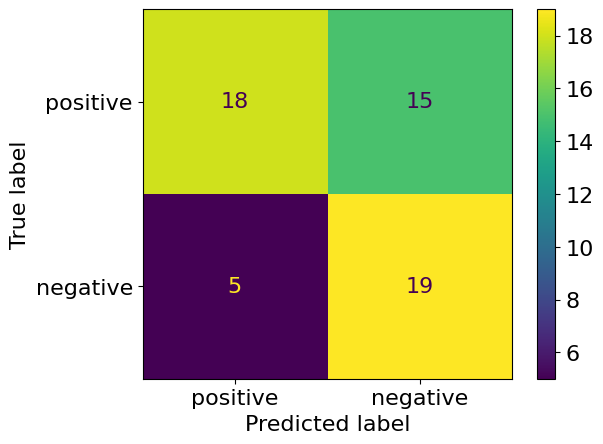

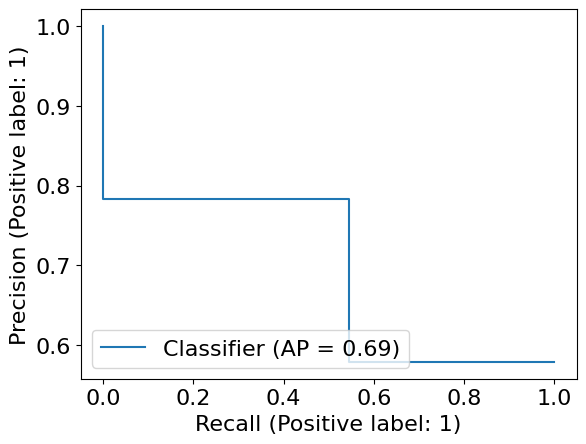

In [36]:
plot_report(eclf, x, y, label='ensamble');plt.show()

Precision: 0.74
Recall: 0.81
F1 Score: 0.78
Accuracy: 0.73
Balanced accuracy: 0.72
AUC: 0.72


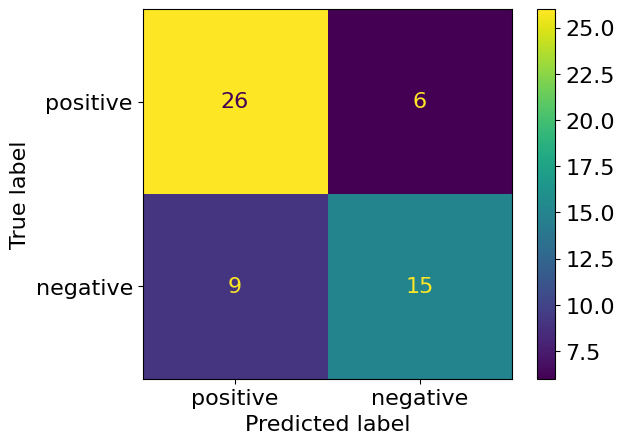

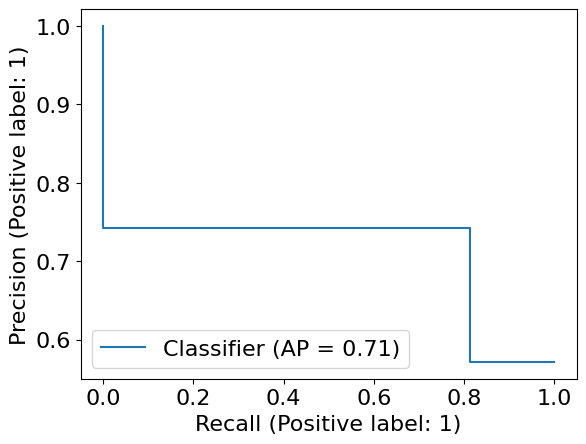

In [73]:
# re-calculate the scores of the current best clinical practice
from sklearn.metrics import (precision_recall_curve,
                                 PrecisionRecallDisplay)

TP = 26
FN = 6
FP = 9
TN = 15

tp = [1]*TP
y_pred = tp
y = tp

tn = [0]*TN
y_pred = y_pred + tn
y = y + tn

fp_pred = [1]*FP
fp_y = [0]*FP
y_pred = y_pred + fp_pred
y = y + fp_y

fn_pred = [0]*FN
fn_y = [1]*FN
y_pred = y_pred + fn_pred
y = y + fn_y


import sklearn
CBP_results = sklearn.metrics.precision_recall_fscore_support(y,y_pred, average='binary')
print('Precision: {:.2f}\nRecall: {:.2f}'.format(CBP_results[0], CBP_results[1]))
print('F1 Score: {:.2f}'.format(sklearn.metrics.f1_score(y,y_pred)))
print('Accuracy: {:.2f}'.format(sklearn.metrics.accuracy_score(y,y_pred)))
print('Balanced accuracy: {:.2f}'.format(sklearn.metrics.balanced_accuracy_score(y,y_pred)))
print('AUC: {:.2f}'.format(sklearn.metrics.roc_auc_score(y,y_pred)))
disp = ConfusionMatrixDisplay.from_predictions(y, y_pred,labels=[1,0], display_labels=['positive','negative'],colorbar=True)
disp = PrecisionRecallDisplay.from_predictions(y,y_pred)


# calculate the measures for the Current best practice



# Precision = TP / (TP+FP) 
